# Notes 2 - Predictors of recorded DS live births

- Train from 2016 and ignore no_congen


## Preparation


In [1]:
import joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
)
from sklearn.model_selection import train_test_split

import repl_utils, stats_utils, data_utils, ml_utils, plot_utils
from variables import Variables as vars

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 47
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)

START_TIME = datetime.now()

OUTPUT_DIR = f"output/0008-predictors-6/{START_TIME:%Y%m%d-%H%M%S}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

-------------------- Environment Information --------------------
date: 2025-12-26T20:30:08.068269
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 197 Stepping 2, GenuineIntel
cores: 16
physical_cores: 16
ram: 95 GB
ram_available: 66 GB
cuda: False
cuda_device_count: 0
cuda_device_0: False
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
lightgbm: 4.6.0
pytorch: 2.9.1
pymc: 5.27.0
pytensor: 2.36.1
arviz: 0.23.0

--------------------
Output directory: output/0008-predictors-6/20251226-203008
--------------------



### Options


In [2]:
START_YEAR = 2016
END_YEAR = 2024
# LightGBM threads
NUM_THREADS = N_CORES - 2
# Splitting data for training, validation and calibration
TRAINING_SPLIT = 0.6
VALIDATION_SPLIT = 0.2
CALIBRATION_SPLIT = 1 - TRAINING_SPLIT - VALIDATION_SPLIT
#
NUM_BOOST_ROUND = 10000
EARLY_STOPPING_ROUNDS = 50
# True to search for hyperparameters
SELECT_HYPERPARAMETERS = True
#
OPTIMIZE_TRIALS = 100

SAVE_PLOTS = True

### Load data


In [3]:
df = data_utils.load_predictors_data(
    from_year=START_YEAR, to_year=END_YEAR, include_unknown=True
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Define initial feature set


In [4]:
numeric = [
    vars.YEAR,
    vars.DBWT,
    vars.PWGT_R,
    vars.WTGAIN,
    vars.BMI,
    vars.MAGE_C,
    vars.FAGECOMB,
]

categorical = [
    # vars.DOB_MM,
    # vars.DOB_WK,
    # "dob_tt_pm",
    vars.BFACIL3,
    vars.SEX,
    vars.PRECARE,
    vars.GESTREC10,
    vars.RF_PDIAB,
    vars.RF_GDIAB,
    vars.RF_PHYPE,
    vars.RF_GHYPE,
    vars.RF_EHYPE,
    vars.RF_PPTERM,
    vars.RF_INFTR,
    vars.RF_FEDRG,
    vars.RF_ARTEC,
    # vars.NO_RISKS,
    vars.LD_INDL,
    vars.LD_AUGM,
    vars.ME_PRES,
    vars.DMETH_REC,
    vars.APGAR5,
    vars.APGAR10,
    vars.AB_AVEN1,
    vars.AB_AVEN6,
    vars.AB_NICU,
    vars.AB_SURF,
    vars.AB_ANTI,
    vars.AB_SEIZ,
    # vars.NO_ABNORM,
    vars.CA_ANEN,
    vars.CA_MNSB,
    vars.CA_CCHD,
    vars.CA_CDH,
    vars.CA_OMPH,
    vars.CA_GAST,
    vars.CA_LIMB,
    vars.CA_CLEFT,
    vars.CA_CLPAL,
    vars.CA_HYPO,
    vars.CA_DISOR,
    # vars.NO_CONGEN,
    vars.MEDUC,
    vars.MRACEHISP,
    vars.FEDUC,
    vars.FRACEHISP,
    vars.PAY_REC,
    vars.WIC,
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_p_n"].replace({pd.NA: 0, np.nan: 0}).astype(np.int32)

X[categorical] = X[categorical].astype("category")

### Split training, validation and calibration data


In [5]:
# use half the data for the training set
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=TRAINING_SPLIT, stratify=y, random_state=RANDOM_SEED
)

# use a quarter of the data for training validation and a quarter for calibration
X_valid, X_cal, y_valid, y_cal = train_test_split(
    X_tmp,
    y_tmp,
    test_size=(VALIDATION_SPLIT / TRAINING_SPLIT),
    stratify=y_tmp,
    random_state=RANDOM_SEED,
)

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

In [6]:
neg_count_train = y_train[y_train == 0].count()
pos_count_train = y_train[y_train == 1].count()
# scale_pos_weight = neg_count_train / pos_count_train

neg_count_valid = y_valid[y_valid == 0].count()
pos_count_valid = y_valid[y_valid == 1].count()

neg_count_cal = y_cal[y_cal == 0].count()
pos_count_cal = y_cal[y_cal == 1].count()

print(
    f"Training set: {neg_count_train} negatives, {pos_count_train} positives, probability positive {pos_count_train / neg_count_train:.8f}"
)
print(
    f"Validation set: {neg_count_valid} negatives, {pos_count_valid} positives, probability positive {pos_count_valid / neg_count_valid:.8f}"
)
print(
    f"Calibration set: {neg_count_cal} negatives, {pos_count_cal} positives, probability positive {pos_count_cal / neg_count_cal:.8f}"
)

Training set: 13428567 negatives, 7124 positives, probability positive 0.00053051
Validation set: 13428568 negatives, 7123 positives, probability positive 0.00053044
Calibration set: 6714284 negatives, 3562 positives, probability positive 0.00053051


In [ ]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "boosting_type": "gbdt",
    "max_bin": 255,  # GPU 63/127; CPU 255
    # for now, we do not scale for better interpretability of outputs
    "scale_pos_weight": 1,
    "force_col_wise": True,
    "seed": RANDOM_SEED,
    "num_threads": NUM_THREADS,
    "verbosity": 1,
}

last_best_params = {    
    "learning_rate": 0.02876437855047539,
    "num_leaves": 93,
    "min_data_in_leaf": 536,
    "min_gain_to_split": 0.16350834484065044,
    "feature_fraction": 0.975019923125186,
    "bagging_fraction": 0.6692811208772795,
    "bagging_freq": 3,
    "lambda_l1": 0.4046983707091733,
    "lambda_l2": 4.526936405831973,
}

## Hyperparameter tuning


In [8]:
def objective(trial):
    trial_params = {
        # required to change min_data_in_leaf across trials without rebuilding the Dataset
        "feature_pre_filter": False,
        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 10000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    # Merge: base_params always present; trial_params override if same key exists
    params = {**base_params, **trial_params}

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(period=10),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]


if SELECT_HYPERPARAMETERS:
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
    )

    study.optimize(objective, n_trials=OPTIMIZE_TRIALS)

    print(study.best_params, study.best_value)

    best = study.best_params
else:
    best = last_best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}
params["feature_pre_filter"] = True  # reset to default for final training

print("Parameters for training:")
for k, v in params.items():
    print(f'  "{k}": {v}')

[I 2025-12-26 20:31:20,546] A new study created in memory with name: no-name-2444b3be-d389-4521-8832-8d3561f025b4


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's average_precision: 0.00748299	valid_0's binary_logloss: 0.00566611
[20]	valid_0's average_precision: 0.0084907	valid_0's binary_logloss: 0.00561539
[30]	valid_0's average_precision: 0.00879488	valid_0's binary_logloss: 0.00562365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's average_precision: 0.00870686	valid_0's binary_logloss: 0.00563727
[LightGBM] [Warning] No further splits with positi

[I 2025-12-26 20:33:00,585] Trial 0 finished with value: 0.012839417406683559 and parameters: {'learning_rate': 0.1665113545148108, 'num_leaves': 471, 'min_data_in_leaf': 5957, 'min_gain_to_split': 0.6708180652754894, 'feature_fraction': 0.6503739758614921, 'bagging_fraction': 0.9946575800312456, 'bagging_freq': 9, 'lambda_l1': 0.0014777937335066246, 'lambda_l2': 6.4254816026391775e-06}. Best is trial 0 with value: 0.012839417406683559.


Early stopping, best iteration is:
[2]	valid_0's average_precision: 0.0128394	valid_0's binary_logloss: 0.00822754
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0170222	valid_0's binary_logloss: 0.00427356
[20]	valid_0's average_precision: 0.0177868	valid_0's binary_logloss: 0.00386779
[30]	valid_0's average_precision: 0.0185025	valid_0's binary_logloss: 0.00378558
[40]	valid_0's average_precision: 0.0195664	valid_0's binary_logloss: 0.0037408
[50]	valid_0's average_precision: 0.020378	valid_0's binary_logloss: 0.00372263
[60]	valid_0's average_precision: 0.0207463	valid_0's binary_logloss: 0.00371777
[70

[I 2025-12-26 20:35:38,378] Trial 1 finished with value: 0.021067774786338467 and parameters: {'learning_rate': 0.08698089325119525, 'num_leaves': 96, 'min_data_in_leaf': 922, 'min_gain_to_split': 0.8352146178370158, 'feature_fraction': 0.7074517443000866, 'bagging_fraction': 0.8228487254852406, 'bagging_freq': 4, 'lambda_l1': 5.272860505399681e-08, 'lambda_l2': 4.95603230406604e-06}. Best is trial 1 with value: 0.021067774786338467.


Early stopping, best iteration is:
[77]	valid_0's average_precision: 0.0210678	valid_0's binary_logloss: 0.00371502
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.00587824	valid_0's binary_logloss: 0.00576831
[20]	valid_0's average_precision: 0.00724375	valid_0's binary_logloss: 0.0056737
[30]	valid_0's average_precision: 0.00725315	valid_0's binary_logloss: 0.00568349
[40]	valid_0's average_precision: 0.00705061	valid_0's binary_logloss: 0.00570301
[50]	valid_0's average_precision: 0.00683946	valid_0's binary_logloss: 0.00572077


[I 2025-12-26 20:36:43,219] Trial 2 finished with value: 0.012085586559470935 and parameters: {'learning_rate': 0.2553439563723462, 'num_leaves': 92, 'min_data_in_leaf': 4109, 'min_gain_to_split': 0.10573627807860098, 'feature_fraction': 0.692239163470249, 'bagging_fraction': 0.7076945236487607, 'bagging_freq': 6, 'lambda_l1': 0.00016941428490345258, 'lambda_l2': 0.04222747531575512}. Best is trial 1 with value: 0.021067774786338467.


Early stopping, best iteration is:
[2]	valid_0's average_precision: 0.0120856	valid_0's binary_logloss: 0.00982628
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0214678	valid_0's binary_logloss: 0.0039463
[20]	valid_0's average_precision: 0.0241453	valid_0's binary_logloss: 0.00379128
[30]	valid_0's average_precision: 0.0250757	valid_0's binary_logloss: 0.00372172
[40]	valid_0's average_precision: 0.0256639	valid_0's binary_logloss: 0.00368391
[50]	valid_0's average_precision: 0.0261426	valid_0's binary_logloss: 0.00366099
[60]	valid_0's average_precision: 0.0264933	valid_0's binary_logloss: 0.00364721
[7

[I 2025-12-26 20:40:04,233] Trial 3 finished with value: 0.026831730624783855 and parameters: {'learning_rate': 0.04110718719249222, 'num_leaves': 151, 'min_data_in_leaf': 4182, 'min_gain_to_split': 0.6212643962746366, 'feature_fraction': 0.7569007228899396, 'bagging_fraction': 0.7060720873860381, 'bagging_freq': 2, 'lambda_l1': 3.785679541149829e-07, 'lambda_l2': 2.409760550735071}. Best is trial 3 with value: 0.026831730624783855.


Early stopping, best iteration is:
[96]	valid_0's average_precision: 0.0268317	valid_0's binary_logloss: 0.00362917
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's average_precision: 0.0217796	valid_0's binary_logloss: 0.00396972
[20]	valid_0's average_precision: 0.0242368	valid_0's binary_logloss: 0.00382842
[30]	valid_0's average_precision: 0.0250848	valid_0's binary_logloss: 0.0037635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's average_precision: 0.0254644	valid_0's binary_logloss: 0.00372272
[50]	valid_0'

[I 2025-12-26 20:41:49,707] Trial 4 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0178594	valid_0's binary_logloss: 0.00395515
[20]	valid_0's average_precision: 0.021814	valid_0's binary_logloss: 0.00375716
[30]	valid_0's average_precision: 0.024399	valid_0's binary_logloss: 0.0037007
[40]	valid_0's average_precision: 0.0259088	valid_0's binary_logloss: 0.00367868
[50]	valid_0's average_precision: 0.0266215	valid_0's binary_logloss: 0.00367051
[60]	valid_0's average_precision: 0.0265573	valid_0's binary_logloss: 0.00366978
[70]	valid_0's average_precision: 0.0265052	valid_0's binary_logloss: 0.00367002
[80]	valid_0's average_precision: 0.02

[I 2025-12-26 20:44:00,446] Trial 5 finished with value: 0.02668229181362643 and parameters: {'learning_rate': 0.09152366923428006, 'num_leaves': 92, 'min_data_in_leaf': 3144, 'min_gain_to_split': 0.0104222039864309, 'feature_fraction': 0.9184681381158282, 'bagging_fraction': 0.8460398473921965, 'bagging_freq': 3, 'lambda_l1': 1.0427471113825183e-08, 'lambda_l2': 5.2872386550966956e-08}. Best is trial 3 with value: 0.026831730624783855.


Early stopping, best iteration is:
[52]	valid_0's average_precision: 0.0266823	valid_0's binary_logloss: 0.00366976
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 20:44:02,679] Trial 6 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0246799	valid_0's binary_logloss: 0.00373992
[20]	valid_0's average_precision: 0.027018	valid_0's binary_logloss: 0.0036607
[30]	valid_0's average_precision: 0.0277369	valid_0's binary_logloss: 0.00363988
[40]	valid_0's average_precision: 0.028347	valid_0's binary_logloss: 0.00363178
[50]	valid_0's average_precision: 0.02812	valid_0's binary_logloss: 0.00362965
[60]	valid_0's average_precision: 0.0279663	valid_0's binary_logloss: 0.00363019
[70]	valid_0's average_precision: 0.0278847	valid_0's binary_logloss: 0.00363164
[80]	valid_0's average_precision: 0.0276

[I 2025-12-26 20:46:03,397] Trial 7 finished with value: 0.028347008239891645 and parameters: {'learning_rate': 0.11733188132700727, 'num_leaves': 83, 'min_data_in_leaf': 1018, 'min_gain_to_split': 0.09101932896043441, 'feature_fraction': 0.6599497384048517, 'bagging_fraction': 0.7361387065545122, 'bagging_freq': 3, 'lambda_l1': 1.3087610084921497e-06, 'lambda_l2': 5.3200579643971455}. Best is trial 7 with value: 0.028347008239891645.


[90]	valid_0's average_precision: 0.0275331	valid_0's binary_logloss: 0.00363605
Early stopping, best iteration is:
[40]	valid_0's average_precision: 0.028347	valid_0's binary_logloss: 0.00363178
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's average_precision: 0.0210688	valid_0's binary_logloss: 0.00390569
[20]	valid_0's average_precision: 0.0244791	valid_0's binary_logloss: 0.00376842
[30]	valid_0's average_precision: 0.0253766	valid_0's binary_logloss: 0.00371275
[40]	valid_0's average_precision: 0.0259173	valid_0's binary_logloss: 0.00368106
[50]	va

[I 2025-12-26 20:48:18,601] Trial 8 finished with value: 0.02612453219267339 and parameters: {'learning_rate': 0.04311883337341494, 'num_leaves': 284, 'min_data_in_leaf': 1476, 'min_gain_to_split': 0.14279898607948516, 'feature_fraction': 0.6256590577837323, 'bagging_fraction': 0.8695328567149718, 'bagging_freq': 1, 'lambda_l1': 1.015843433114193e-06, 'lambda_l2': 0.28882903972505924}. Best is trial 7 with value: 0.028347008239891645.


Early stopping, best iteration is:
[49]	valid_0's average_precision: 0.0261245	valid_0's binary_logloss: 0.00366349
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0188454	valid_0's binary_logloss: 0.00393751
[20]	valid_0's average_precision: 0.0215408	valid_0's binary_logloss: 0.00371839


[I 2025-12-26 20:48:50,856] Trial 9 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0247703	valid_0's binary_logloss: 0.00414566
[20]	valid_0's average_precision: 0.026067	valid_0's binary_logloss: 0.00401439
[30]	valid_0's average_precision: 0.0268731	valid_0's binary_logloss: 0.00392962
[40]	valid_0's average_precision: 0.0273356	valid_0's binary_logloss: 0.00387055
[50]	valid_0's average_precision: 0.0277333	valid_0's binary_logloss: 0.00382735
[60]	valid_0's average_precision: 0.0281017	valid_0's binary_logloss: 0.00379217
[70]	valid_0's average_precision: 0.0283416	valid_0's binary_logloss: 0.00376411
[80]	valid_0's average_precision: 0.

[I 2025-12-26 20:59:56,947] Trial 10 finished with value: 0.03090266240887637 and parameters: {'learning_rate': 0.012830785899284807, 'num_leaves': 33, 'min_data_in_leaf': 547, 'min_gain_to_split': 0.991464161467293, 'feature_fraction': 0.8387425817374393, 'bagging_fraction': 0.7415904274655329, 'bagging_freq': 9, 'lambda_l1': 3.5131420222871816, 'lambda_l2': 0.0018286902305550128}. Best is trial 10 with value: 0.03090266240887637.


Early stopping, best iteration is:
[513]	valid_0's average_precision: 0.0309027	valid_0's binary_logloss: 0.00360858
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 20:59:58,726] Trial 11 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:00:00,568] Trial 12 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:00:02,625] Trial 13 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:00:10,701] Trial 14 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0228644	valid_0's binary_logloss: 0.00405229
[20]	valid_0's average_precision: 0.0244287	valid_0's binary_logloss: 0.00391468
[30]	valid_0's average_precision: 0.0251675	valid_0's binary_logloss: 0.00383063
[40]	valid_0's average_precision: 0.0257073	valid_0's binary_logloss: 0.00377563
[50]	valid_0's average_precision: 0.0261694	valid_0's binary_logloss: 0.00373729
[60]	valid_0's average_precision: 0.0263968	valid_0's binary_logloss: 0.00371062
[70]	valid_0's average_precision: 0.0265322	valid_0's binary_logloss: 0.00369065
[80]	valid_0's average_precision: 0

[I 2025-12-26 21:03:51,910] Trial 15 finished with value: 0.02701095641780767 and parameters: {'learning_rate': 0.018706271869766613, 'num_leaves': 196, 'min_data_in_leaf': 2432, 'min_gain_to_split': 0.25115562904807576, 'feature_fraction': 0.8670909303512909, 'bagging_fraction': 0.7933953666931712, 'bagging_freq': 10, 'lambda_l1': 0.053150422199222544, 'lambda_l2': 0.02116178102026317}. Best is trial 10 with value: 0.03090266240887637.


Early stopping, best iteration is:
[129]	valid_0's average_precision: 0.027011	valid_0's binary_logloss: 0.00364149
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:03:55,088] Trial 16 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:03:57,324] Trial 17 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:04:07,095] Trial 18 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:04:17,654] Trial 19 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:04:19,467] Trial 20 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0227686	valid_0's binary_logloss: 0.00407365
[20]	valid_0's average_precision: 0.0245572	valid_0's binary_logloss: 0.00393173
[30]	valid_0's average_precision: 0.0254449	valid_0's binary_logloss: 0.0038471
[40]	valid_0's average_precision: 0.025934	valid_0's binary_logloss: 0.00379121
[50]	valid_0's average_precision: 0.0263243	valid_0's binary_logloss: 0.00375133
[60]	valid_0's average_precision: 0.0264122	valid_0's binary_logloss: 0.0037236
[70]	valid_0's average_precision: 0.0265955	valid_0's binary_logloss: 0.00370168
[80]	valid_0's average_precision: 0.02

[I 2025-12-26 21:05:47,372] Trial 21 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:05:51,083] Trial 22 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:05:55,026] Trial 23 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:05:57,236] Trial 24 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:05:59,988] Trial 25 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.024316	valid_0's binary_logloss: 0.0041177
[20]	valid_0's average_precision: 0.0254833	valid_0's binary_logloss: 0.00398329
[30]	valid_0's average_precision: 0.0262853	valid_0's binary_logloss: 0.00389901
[40]	valid_0's average_precision: 0.0268037	valid_0's binary_logloss: 0.00384054
[50]	valid_0's average_precision: 0.0269322	valid_0's binary_logloss: 0.00379669
[60]	valid_0's average_precision: 0.0271691	valid_0's binary_logloss: 0.00376445
[70]	valid_0's average_precision: 0.0273472	valid_0's binary_logloss: 0.00373801
[80]	valid_0's average_precision: 0.0

[I 2025-12-26 21:09:35,364] Trial 26 finished with value: 0.0277315532898865 and parameters: {'learning_rate': 0.013460270856717358, 'num_leaves': 132, 'min_data_in_leaf': 956, 'min_gain_to_split': 0.33232183008592064, 'feature_fraction': 0.9055989029417402, 'bagging_fraction': 0.7108092810578236, 'bagging_freq': 7, 'lambda_l1': 0.13298754126074036, 'lambda_l2': 0.06352098850547819}. Best is trial 10 with value: 0.03090266240887637.


Early stopping, best iteration is:
[145]	valid_0's average_precision: 0.0277316	valid_0's binary_logloss: 0.00365403
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-26 21:09:45,976] Trial 27 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.025574	valid_0's binary_logloss: 0.00411185
[20]	valid_0's average_precision: 0.0267532	valid_0's binary_logloss: 0.00397795
[30]	valid_0's average_precision: 0.027289	valid_0's binary_logloss: 0.00389595
[40]	valid_0's average_precision: 0.0277015	valid_0's binary_logloss: 0.00383838
[50]	valid_0's average_precision: 0.0279734	valid_0's binary_logloss: 0.00379557
[60]	valid_0's average_precision: 0.028207	valid_0's binary_logloss: 0.00376321
[70]	valid_0's average_precision: 0.0283322	valid_0's binary_logloss: 0.00373808
[80]	valid_0's average_precision: 0.02

[I 2025-12-26 21:12:32,375] Trial 28 finished with value: 0.02851896596875667 and parameters: {'learning_rate': 0.013502783408512959, 'num_leaves': 76, 'min_data_in_leaf': 683, 'min_gain_to_split': 0.32811888751679813, 'feature_fraction': 0.9524519553415058, 'bagging_fraction': 0.6554934460302768, 'bagging_freq': 6, 'lambda_l1': 0.000281011782269478, 'lambda_l2': 0.09538030333436999}. Best is trial 10 with value: 0.03090266240887637.


Early stopping, best iteration is:
[119]	valid_0's average_precision: 0.028519	valid_0's binary_logloss: 0.00367011
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0264065	valid_0's binary_logloss: 0.00397675
[20]	valid_0's average_precision: 0.0273315	valid_0's binary_logloss: 0.00383193
[30]	valid_0's average_precision: 0.0281437	valid_0's binary_logloss: 0.00375525
[40]	valid_0's average_precision: 0.0284838	valid_0's binary_logloss: 0.00370999
[50]	valid_0's average_precision: 0.0286912	valid_0's binary_logloss: 0.00368108
[60]	valid_0's average_precision: 0.0288215	valid_0's binary_logloss: 0.00366201


[I 2025-12-26 21:16:22,914] Trial 29 finished with value: 0.029183356300155328 and parameters: {'learning_rate': 0.028547886625480696, 'num_leaves': 76, 'min_data_in_leaf': 681, 'min_gain_to_split': 0.7401343603477106, 'feature_fraction': 0.9494774960358453, 'bagging_fraction': 0.6446159073807383, 'bagging_freq': 4, 'lambda_l1': 0.0006294858540406005, 'lambda_l2': 1.2028816635620356}. Best is trial 10 with value: 0.03090266240887637.


Early stopping, best iteration is:
[143]	valid_0's average_precision: 0.0291834	valid_0's binary_logloss: 0.00361817
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:16:25,836] Trial 30 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's average_precision: 0.023181	valid_0's binary_logloss: 0.00418381
[20]	valid_0's average_precision: 0.0256161	valid_0's binary_logloss: 0.00403244
[30]	valid_0's average_precision: 0.0266598	valid_0's binary_logloss: 0.00394973
[40]	valid_0's average_precision: 0.027488	valid_0's binary_logloss: 0.00388558
[50]	valid_0's average_precision: 0.0279386	valid_0's binary_logloss: 0.00383681
[60]	valid_0's average_precision: 0.0284443	valid_0's binary_logloss: 0.0038004
[70]	valid_0's average_precision: 0.0287945	

[I 2025-12-26 21:23:06,657] Trial 31 finished with value: 0.030461130414952266 and parameters: {'learning_rate': 0.012747277506102606, 'num_leaves': 79, 'min_data_in_leaf': 712, 'min_gain_to_split': 0.9040177703809935, 'feature_fraction': 0.6660545957957424, 'bagging_fraction': 0.6355161614593131, 'bagging_freq': 2, 'lambda_l1': 6.998179466253792e-06, 'lambda_l2': 1.1656145872970551}. Best is trial 10 with value: 0.03090266240887637.


Early stopping, best iteration is:
[264]	valid_0's average_precision: 0.0304611	valid_0's binary_logloss: 0.00361861
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:23:08,730] Trial 32 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0252865	valid_0's binary_logloss: 0.00417509
[20]	valid_0's average_precision: 0.0264003	valid_0's binary_logloss: 0.00404538
[30]	valid_0's average_precision: 0.0270017	valid_0's binary_logloss: 0.00396248
[40]	valid_0's average_precision: 0.0274566	valid_0's binary_logloss: 0.00390175
[50]	valid_0's average_precision: 0.0278464	valid_0's binary_logloss: 0.00385439
[60]	valid_0's average_precision: 0.0281216	valid_0's binary_logloss: 0.00381864
[70]	valid_0's average_precision: 0.0283761	valid_0's binary_logloss: 0.00378931
[80]	valid_0's average_precision: 0

[I 2025-12-26 21:27:18,453] Trial 33 finished with value: 0.029066127349536924 and parameters: {'learning_rate': 0.010062336157490248, 'num_leaves': 93, 'min_data_in_leaf': 577, 'min_gain_to_split': 0.9093239798720465, 'feature_fraction': 0.8933334816086179, 'bagging_fraction': 0.6032441166884007, 'bagging_freq': 2, 'lambda_l1': 5.795476296413257e-05, 'lambda_l2': 0.0943197647111445}. Best is trial 10 with value: 0.03090266240887637.


[230]	valid_0's average_precision: 0.0290202	valid_0's binary_logloss: 0.00363883
Early stopping, best iteration is:
[180]	valid_0's average_precision: 0.0290661	valid_0's binary_logloss: 0.00365555
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:27:22,146] Trial 34 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:27:24,038] Trial 35 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:27:33,101] Trial 36 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0249804	valid_0's binary_logloss: 0.004046
[20]	valid_0's average_precision: 0.0258067	valid_0's binary_logloss: 0.00391491


[I 2025-12-26 21:27:55,249] Trial 37 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0245565	valid_0's binary_logloss: 0.00411874
[20]	valid_0's average_precision: 0.0263411	valid_0's binary_logloss: 0.00397052
[30]	valid_0's average_precision: 0.0272549	valid_0's binary_logloss: 0.00388677
[40]	valid_0's average_precision: 0.0279149	valid_0's binary_logloss: 0.00382741
[50]	valid_0's average_precision: 0.0285187	valid_0's binary_logloss: 0.00378234
[60]	valid_0's average_precision: 0.0288742	valid_0's binary_logloss: 0.00375032
[70]	valid_0's average_precision: 0.0291722	valid_0's binary_logloss: 0.00372375
[80]	valid_0's average_precision: 0

[I 2025-12-26 21:32:29,697] Trial 38 finished with value: 0.030287930962902568 and parameters: {'learning_rate': 0.0153985298523024, 'num_leaves': 88, 'min_data_in_leaf': 565, 'min_gain_to_split': 0.7924490188925064, 'feature_fraction': 0.7472358892283593, 'bagging_fraction': 0.6911509279127246, 'bagging_freq': 2, 'lambda_l1': 4.066790498388487e-06, 'lambda_l2': 0.6322218008628573}. Best is trial 10 with value: 0.03090266240887637.


Early stopping, best iteration is:
[173]	valid_0's average_precision: 0.0302879	valid_0's binary_logloss: 0.00362845
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:32:34,632] Trial 39 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:32:36,951] Trial 40 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.026528	valid_0's binary_logloss: 0.00409934
[20]	valid_0's average_precision: 0.0272698	valid_0's binary_logloss: 0.003961
[30]	valid_0's average_precision: 0.0279417	valid_0's binary_logloss: 0.00388092
[40]	valid_0's average_precision: 0.028376	valid_0's binary_logloss: 0.00382342
[50]	valid_0's average_precision: 0.0286909	valid_0's binary_logloss: 0.00378052
[60]	valid_0's average_precision: 0.0290822	valid_0's binary_logloss: 0.0037493
[70]	valid_0's average_precision: 0.0293377	valid_0's binary_logloss: 0.00372388
[80]	valid_0's average_precision: 0.0293

[I 2025-12-26 21:37:04,698] Trial 41 finished with value: 0.029851236627189786 and parameters: {'learning_rate': 0.0155158501425605, 'num_leaves': 96, 'min_data_in_leaf': 500, 'min_gain_to_split': 0.9456215579163578, 'feature_fraction': 0.7674400221912645, 'bagging_fraction': 0.6269930308456275, 'bagging_freq': 2, 'lambda_l1': 3.5697942553442897e-07, 'lambda_l2': 0.09874397433206691}. Best is trial 10 with value: 0.03090266240887637.


Early stopping, best iteration is:
[172]	valid_0's average_precision: 0.0298512	valid_0's binary_logloss: 0.00363456
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:37:08,876] Trial 42 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:37:10,758] Trial 43 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:37:13,188] Trial 44 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:37:15,231] Trial 45 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-26 21:37:18,843] Trial 46 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:37:21,608] Trial 47 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:37:30,604] Trial 48 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:37:34,085] Trial 49 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:37:37,764] Trial 50 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0214331	valid_0's binary_logloss: 0.00421866
[20]	valid_0's average_precision: 0.0237091	valid_0's binary_logloss: 0.00406659


[I 2025-12-26 21:38:04,398] Trial 51 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:38:06,513] Trial 52 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:38:08,885] Trial 53 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:38:10,801] Trial 54 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:38:12,595] Trial 55 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:38:18,401] Trial 56 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:38:20,713] Trial 57 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:38:30,389] Trial 58 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:38:38,073] Trial 59 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:38:44,306] Trial 60 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:38:51,402] Trial 61 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:38:58,369] Trial 62 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0246673	valid_0's binary_logloss: 0.0040509
[20]	valid_0's average_precision: 0.0265557	valid_0's binary_logloss: 0.00390593
[30]	valid_0's average_precision: 0.0276079	valid_0's binary_logloss: 0.0038217
[40]	valid_0's average_precision: 0.0283244	valid_0's binary_logloss: 0.00376648
[50]	valid_0's average_precision: 0.0287119	valid_0's binary_logloss: 0.00372874
[60]	valid_0's average_precision: 0.0290058	valid_0's binary_logloss: 0.00370172
[70]	valid_0's average_precision: 0.0291331	valid_0's binary_logloss: 0.00368177
[80]	valid_0's average_precision: 0.0

[I 2025-12-26 21:43:35,134] Trial 63 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:43:38,537] Trial 64 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0257931	valid_0's binary_logloss: 0.00406343
[20]	valid_0's average_precision: 0.026768	valid_0's binary_logloss: 0.00393012


[I 2025-12-26 21:44:01,763] Trial 65 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:44:04,259] Trial 66 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0225974	valid_0's binary_logloss: 0.00400573
[20]	valid_0's average_precision: 0.0236812	valid_0's binary_logloss: 0.0038699


[I 2025-12-26 21:44:29,333] Trial 67 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:44:31,451] Trial 68 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:44:33,962] Trial 69 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0238727	valid_0's binary_logloss: 0.0040176
[20]	valid_0's average_precision: 0.026792	valid_0's binary_logloss: 0.00385373
[30]	valid_0's average_precision: 0.0279769	valid_0's binary_logloss: 0.00376854
[40]	valid_0's average_precision: 0.028949	valid_0's binary_logloss: 0.00371815
[50]	valid_0's average_precision: 0.02974	valid_0's binary_logloss: 0.00368561
[60]	valid_0's average_precision: 0.0299738	valid_0's binary_logloss: 0.00366529
[70]	valid_0's average_precision: 0.0301979	valid_0's binary_logloss: 0.00365085
[80]	valid_0's average_precision: 0.0304

[I 2025-12-26 21:49:12,464] Trial 70 finished with value: 0.03130692000545516 and parameters: {'learning_rate': 0.02876437855047539, 'num_leaves': 93, 'min_data_in_leaf': 536, 'min_gain_to_split': 0.16350834484065044, 'feature_fraction': 0.975019923125186, 'bagging_fraction': 0.6692811208772795, 'bagging_freq': 3, 'lambda_l1': 0.4046983707091733, 'lambda_l2': 4.526936405831973}. Best is trial 70 with value: 0.03130692000545516.


Early stopping, best iteration is:
[165]	valid_0's average_precision: 0.0313069	valid_0's binary_logloss: 0.00361298
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:49:14,648] Trial 71 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:49:16,882] Trial 72 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:49:19,000] Trial 73 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:49:26,206] Trial 74 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:49:27,956] Trial 75 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:49:30,151] Trial 76 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:49:33,466] Trial 77 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0259684	valid_0's binary_logloss: 0.00389521
[20]	valid_0's average_precision: 0.0270922	valid_0's binary_logloss: 0.00375864
[30]	valid_0's average_precision: 0.0275443	valid_0's binary_logloss: 0.00370052
[40]	valid_0's average_precision: 0.0279011	valid_0's binary_logloss: 0.00366795
[50]	valid_0's average_precision: 0.0281669	valid_0's binary_logloss: 0.00364939
[60]	valid_0's average_precision: 0.0282822	valid_0's binary_logloss: 0.00363855
[70]	valid_0's average_precision: 0.0282735	valid_0's binary_logloss: 0.00363275
[80]	valid_0's average_precision: 0

[I 2025-12-26 21:51:17,251] Trial 78 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:51:20,336] Trial 79 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:51:30,085] Trial 80 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0255854	valid_0's binary_logloss: 0.00373922
[20]	valid_0's average_precision: 0.0281088	valid_0's binary_logloss: 0.00365684
[30]	valid_0's average_precision: 0.029332	valid_0's binary_logloss: 0.00363343
[40]	valid_0's average_precision: 0.0296828	valid_0's binary_logloss: 0.00362687
[50]	valid_0's average_precision: 0.0295436	valid_0's binary_logloss: 0.00362569
[60]	valid_0's average_precision: 0.0295097	valid_0's binary_logloss: 0.00362481
[70]	valid_0's average_precision: 0.0290515	valid_0's binary_logloss: 0.00362644
[80]	valid_0's average_precision: 0.

[I 2025-12-26 21:53:21,734] Trial 81 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:53:24,555] Trial 82 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:53:28,401] Trial 83 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:53:32,021] Trial 84 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:53:34,436] Trial 85 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:53:39,154] Trial 86 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:53:42,053] Trial 87 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-26 21:53:46,980] Trial 88 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.025813	valid_0's binary_logloss: 0.00410933
[20]	valid_0's average_precision: 0.0264702	valid_0's binary_logloss: 0.00398018


[I 2025-12-26 21:54:10,752] Trial 89 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:54:13,900] Trial 90 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:54:21,910] Trial 91 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0256865	valid_0's binary_logloss: 0.00408355
[20]	valid_0's average_precision: 0.0270684	valid_0's binary_logloss: 0.00394828
[30]	valid_0's average_precision: 0.0280208	valid_0's binary_logloss: 0.00386416
[40]	valid_0's average_precision: 0.0284535	valid_0's binary_logloss: 0.00380723
[50]	valid_0's average_precision: 0.0287701	valid_0's binary_logloss: 0.00376562
[60]	valid_0's average_precision: 0.0288606	valid_0's binary_logloss: 0.00373641
[70]	valid_0's average_precision: 0.0290759	valid_0's binary_logloss: 0.0037124
[80]	valid_0's average_precision: 0.

[I 2025-12-26 21:55:41,536] Trial 92 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:55:43,832] Trial 93 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0255333	valid_0's binary_logloss: 0.00414088
[20]	valid_0's average_precision: 0.027589	valid_0's binary_logloss: 0.00400219
[30]	valid_0's average_precision: 0.0282374	valid_0's binary_logloss: 0.0039168
[40]	valid_0's average_precision: 0.0285859	valid_0's binary_logloss: 0.00385647
[50]	valid_0's average_precision: 0.0288309	valid_0's binary_logloss: 0.00381122
[60]	valid_0's average_precision: 0.0290571	valid_0's binary_logloss: 0.0037765
[70]	valid_0's average_precision: 0.0293237	valid_0's binary_logloss: 0.00374829
[80]	valid_0's average_precision: 0.02

[I 2025-12-26 21:57:54,761] Trial 94 finished with value: 0.02939932078506328 and parameters: {'learning_rate': 0.012316435889855464, 'num_leaves': 111, 'min_data_in_leaf': 583, 'min_gain_to_split': 0.10980131171254912, 'feature_fraction': 0.9086693554309759, 'bagging_fraction': 0.7020516495710116, 'bagging_freq': 6, 'lambda_l1': 0.08441832780604194, 'lambda_l2': 0.31894076696174994}. Best is trial 70 with value: 0.03130692000545516.


Early stopping, best iteration is:
[79]	valid_0's average_precision: 0.0293993	valid_0's binary_logloss: 0.00372821
[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:57:56,989] Trial 95 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:58:00,586] Trial 96 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:58:08,349] Trial 97 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:58:11,916] Trial 98 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds


[I 2025-12-26 21:58:13,990] Trial 99 pruned. Trial was pruned at iteration 1.


{'learning_rate': 0.02876437855047539, 'num_leaves': 93, 'min_data_in_leaf': 536, 'min_gain_to_split': 0.16350834484065044, 'feature_fraction': 0.975019923125186, 'bagging_fraction': 0.6692811208772795, 'bagging_freq': 3, 'lambda_l1': 0.4046983707091733, 'lambda_l2': 4.526936405831973} 0.03130692000545516
Parameters for training:
  "objective": binary
  "metric": ['average_precision', 'binary_logloss']
  "boosting_type": gbdt
  "max_bin": 255
  "scale_pos_weight": 1
  "force_col_wise": True
  "seed": 47
  "num_threads": 14
  "verbosity": 1
  "learning_rate": 0.02876437855047539
  "num_leaves": 93
  "min_data_in_leaf": 536
  "min_gain_to_split": 0.16350834484065044
  "feature_fraction": 0.975019923125186
  "bagging_fraction": 0.6692811208772795
  "bagging_freq": 3
  "lambda_l1": 0.4046983707091733
  "lambda_l2": 4.526936405831973
  "feature_pre_filter": True


## Model 0 (all initial predictors)


In [9]:
model_idx = 0
model_name = f"Model {model_idx} (all initial predictors)"

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	train's average_precision: 0.0263685	train's binary_logloss: 0.0039862	valid's average_precision: 0.0238727	valid's binary_logloss: 0.0040176
[20]	train's average_precision: 0.030081	train's binary_logloss: 0.00380299	valid's average_precision: 0.026792	valid's binary_logloss: 0.00385373
[30]	train's average_precision: 0.0335344	train's binary_logloss: 0.00370118	valid's average_precision: 0.0279769	valid's binary_logloss: 0.00376854
[40]	train's average_precision: 0.0359198	train's binary_logloss: 0.00363644	valid's average_precision: 0.028949	valid's binary_logloss: 0.00371815
[50]	train'

In [10]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [11]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.886301
1,Validation AP,0.031307
2,Validation log loss,0.003613
3,Precision at 10000,0.083700
4,Recall at 10000,0.117507
5,Precision (threshold=0.01),0.027042
6,Recall (threshold=0.01),0.284711


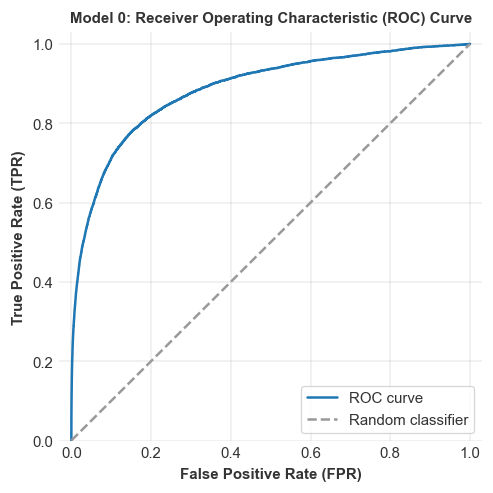

In [12]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

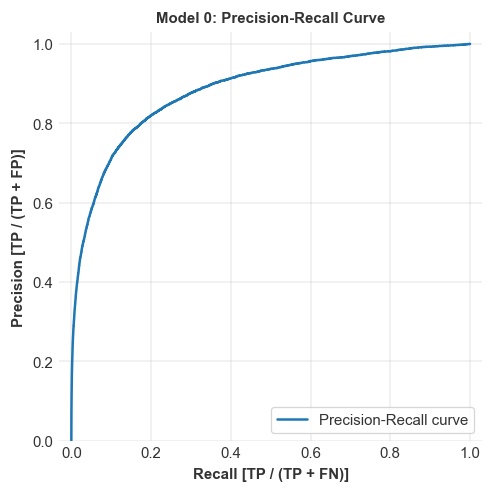

In [13]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

#### Feature importance


In [14]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
21,ab_nicu,139896.643885
47,mage_c,67564.614050
43,dbwt,28075.577024
35,ca_disor,25171.386244
27,ca_cchd,17201.080964
3,gestrec10,14982.380914
45,wtgain,12411.057490
46,bmi,11246.166643
44,pwgt_r,9652.857906
48,fagecomb,8804.324732


### Evaluation subset for permutation importances and SHAP analysis


In [15]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

In [16]:
model_wrapped = ml_utils.LGBMEstimator(gbm)

In [17]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
27,ca_cchd,0.010925,0.000368
35,ca_disor,0.010833,0.000400
47,mage_c,0.008930,0.000312
21,ab_nicu,0.004579,0.000527
43,dbwt,0.003641,0.000401
3,gestrec10,0.002335,0.000184
16,dmeth_rec,0.001248,0.000158
45,wtgain,0.000788,0.000196
0,bfacil3,0.000625,0.000213
42,year,0.000541,0.000142


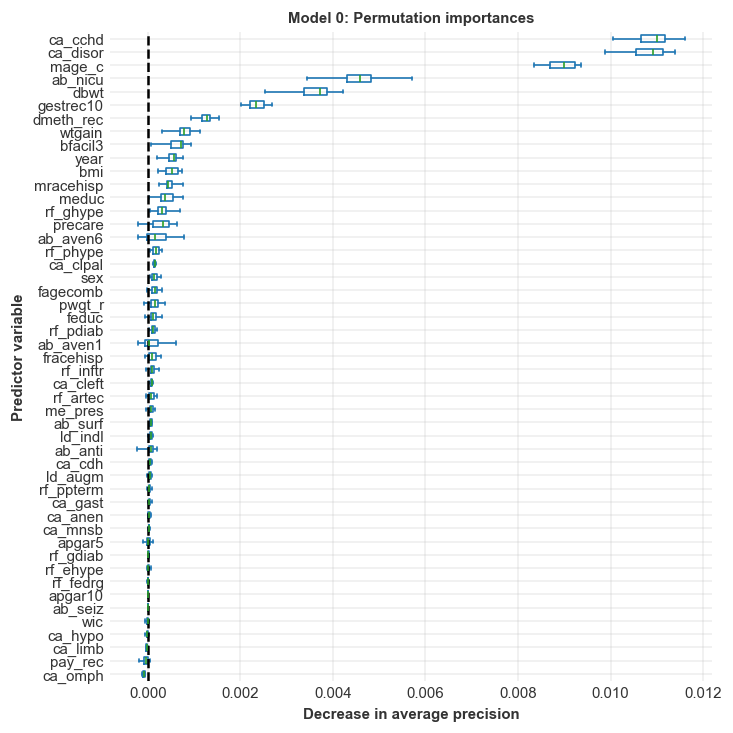

In [18]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

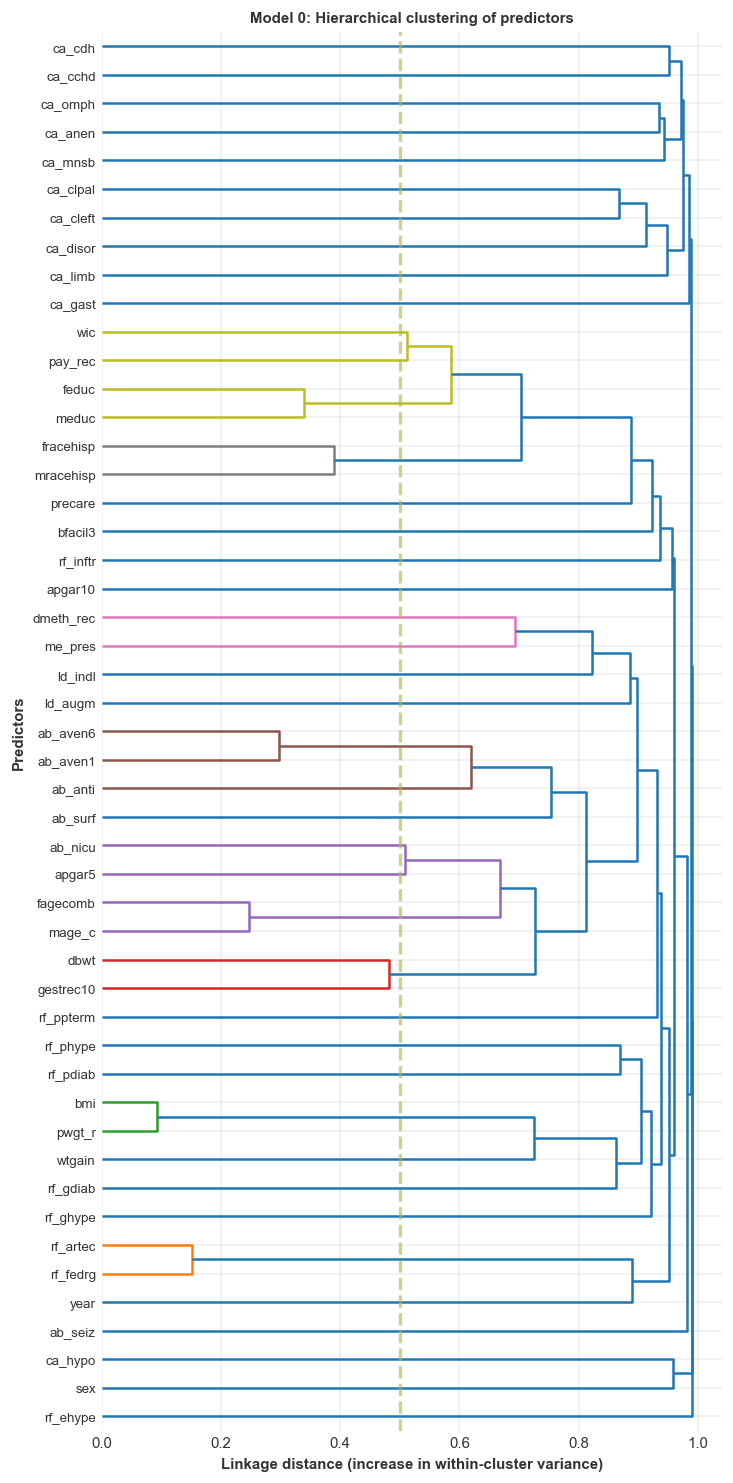

In [19]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

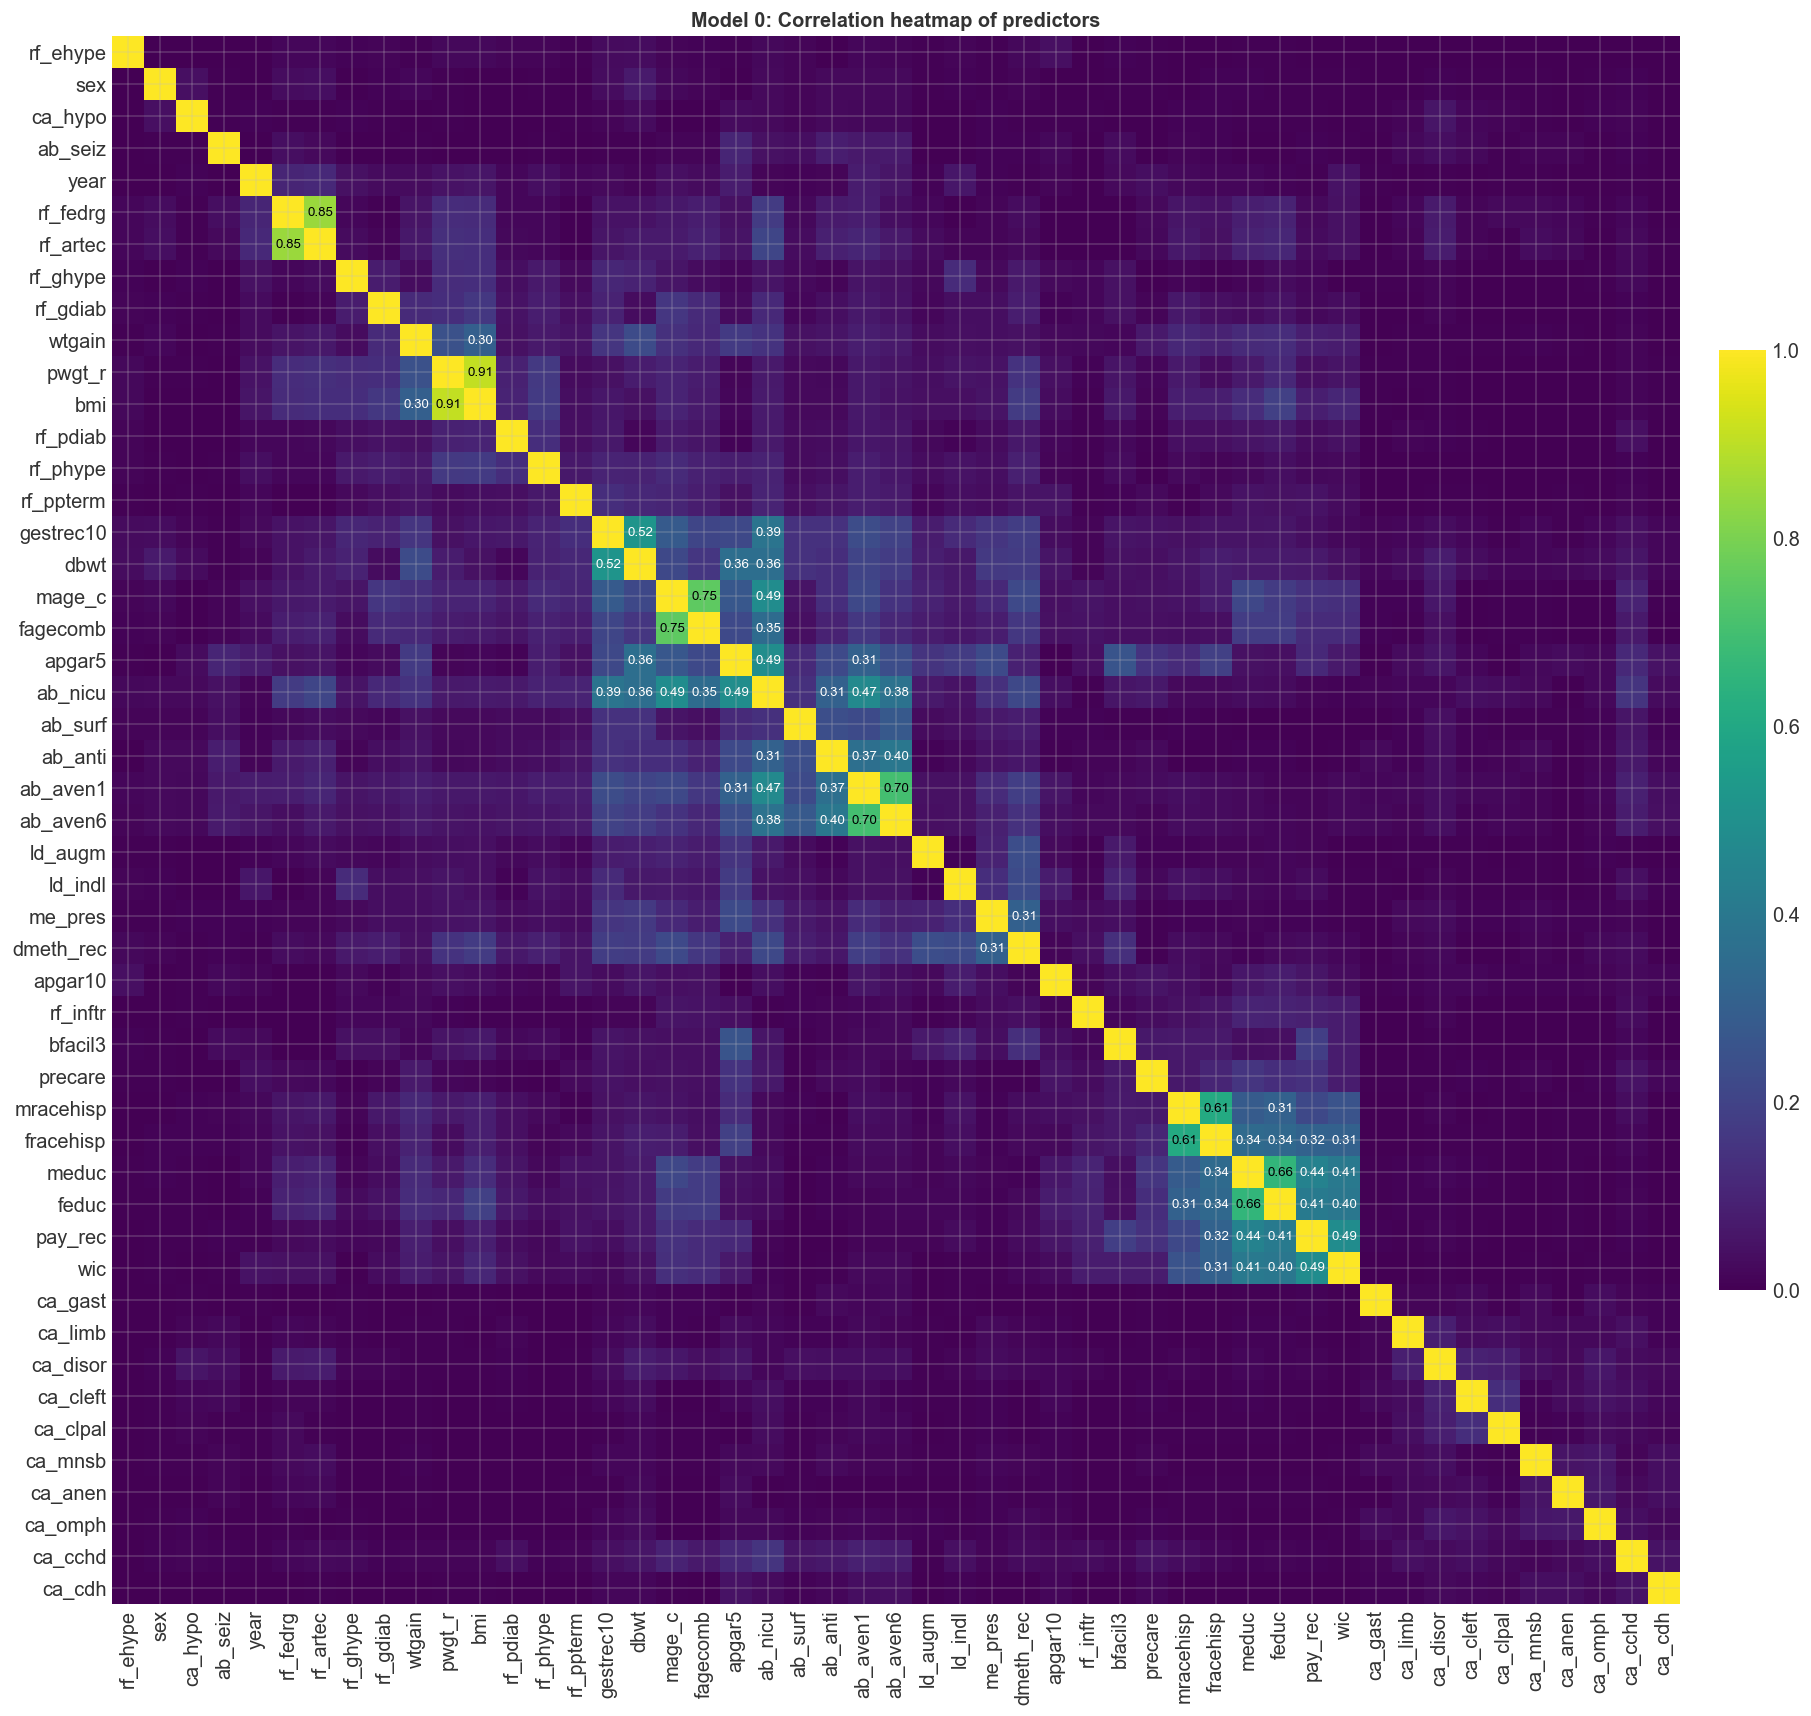

In [20]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [21]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clusterin

,feature,mean_abs_shap
21,ab_nicu,1.028843
47,mage_c,0.792440
43,dbwt,0.325831
3,gestrec10,0.324510
19,ab_aven1,0.185176
37,mracehisp,0.120873
27,ca_cchd,0.115572
35,ca_disor,0.099478
45,wtgain,0.085095
20,ab_aven6,0.071242


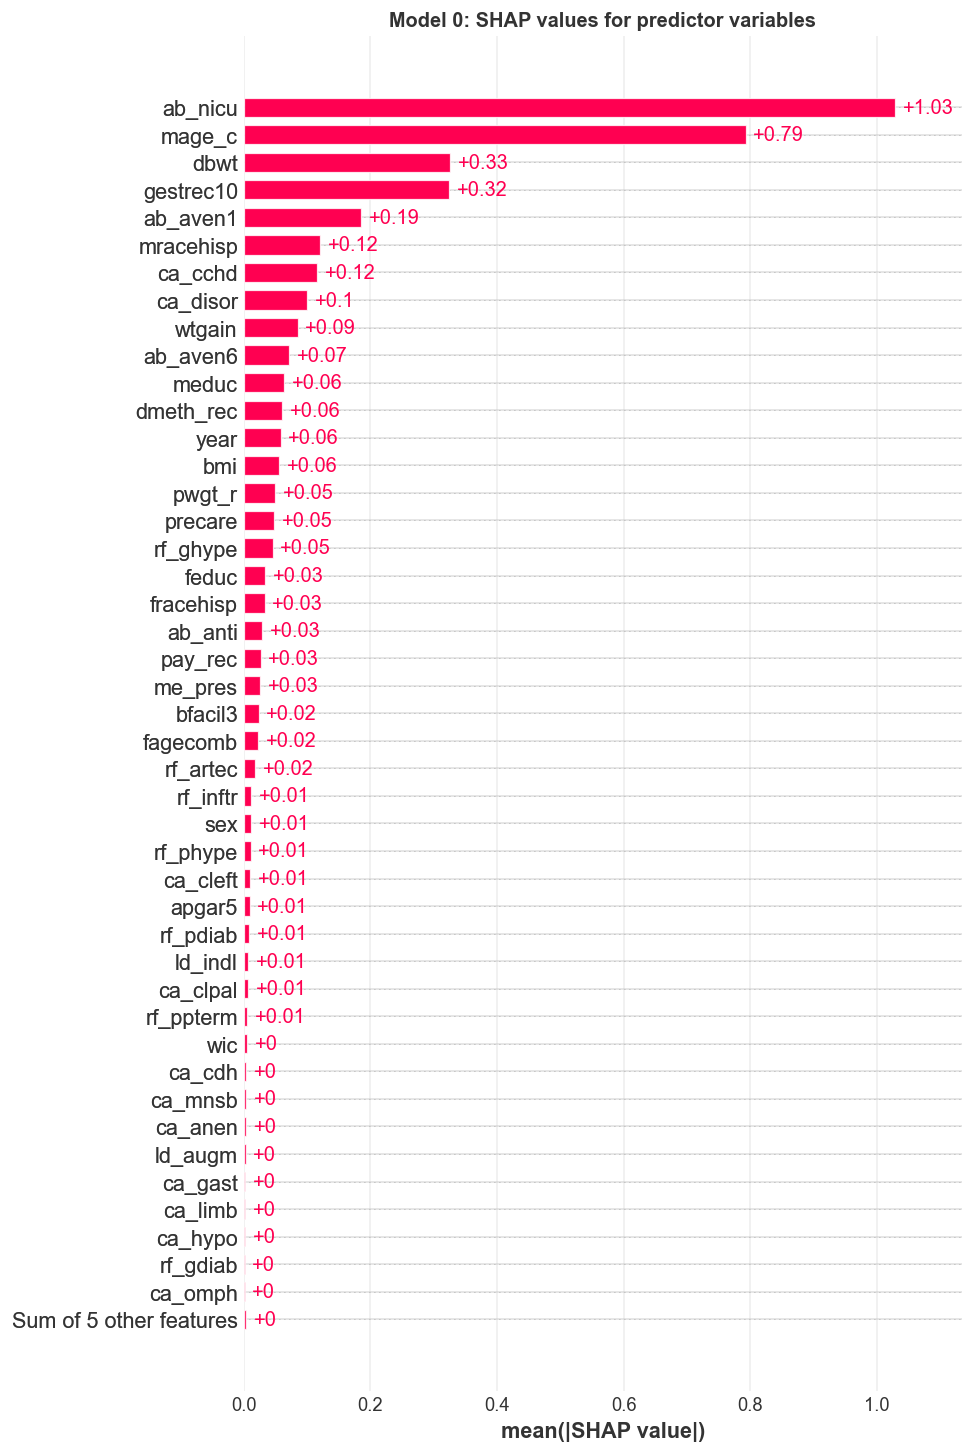

<Figure size 492x348 with 0 Axes>

In [26]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 12))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=45, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

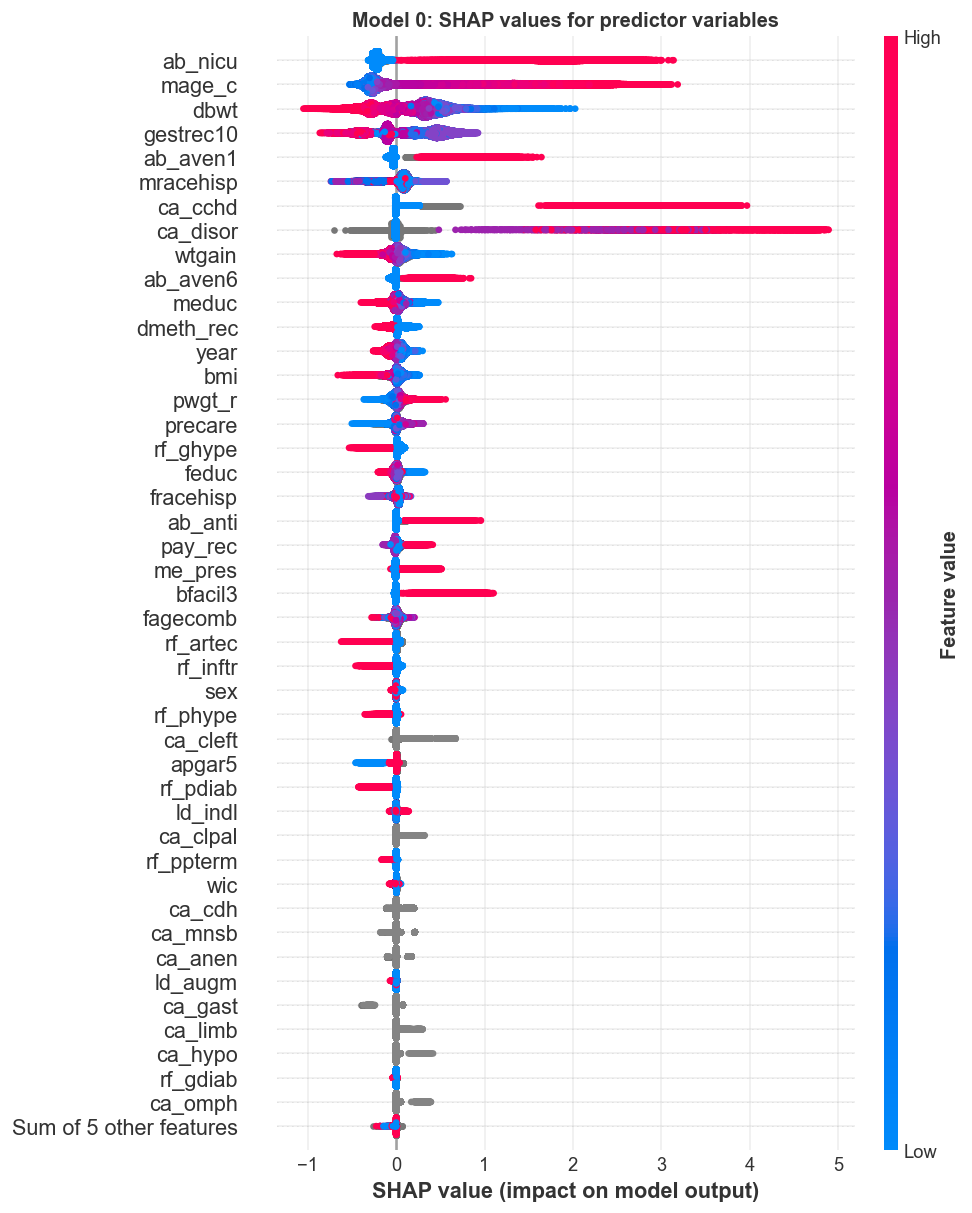

<Figure size 492x348 with 0 Axes>

In [25]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=45, plot_size=(8, 10))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

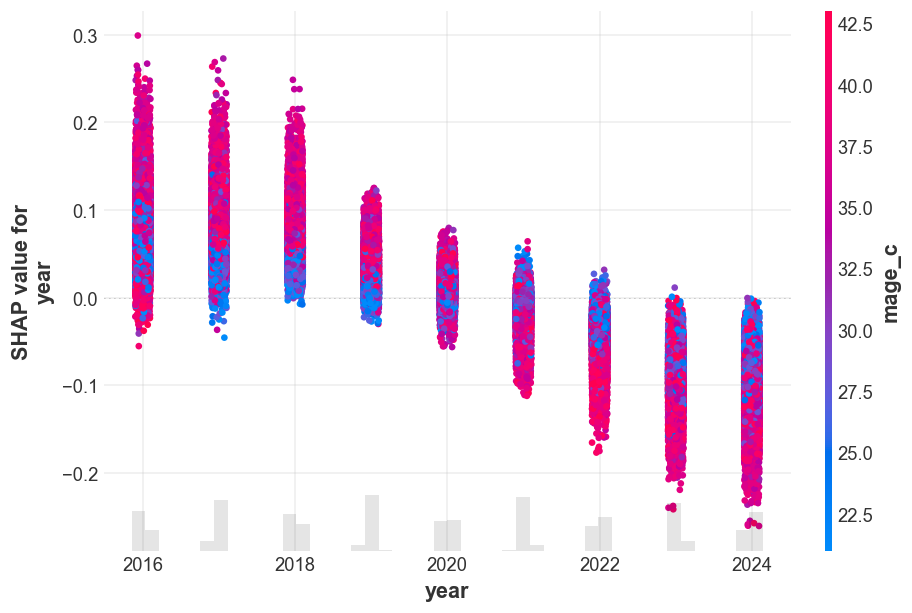

<Figure size 492x348 with 0 Axes>

In [24]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
# ax.set_title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 1


In [27]:
features_to_remove_0 = [
    "ca_limb",
    "ca_hypo",
    "rf_gdiab",
    "ca_omph",
    "rf_fedrg",
    "rf_ehype",
    "apgar10",
    "ab_seiz",
    "wic",
    "fagecomb",
]

X_train = X_train.drop(columns=features_to_remove_0)
X_valid = X_valid.drop(columns=features_to_remove_0)
X_cal = X_cal.drop(columns=features_to_remove_0)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_0]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 1
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_0)} predictors)"
)

print(f"Features removed: {features_to_remove_0}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['ca_limb', 'ca_hypo', 'rf_gdiab', 'ca_omph', 'rf_fedrg', 'rf_ehype', 'apgar10', 'ab_seiz', 'wic', 'fagecomb']
Features remaining: ['bfacil3', 'sex', 'precare', 'gestrec10', 'rf_pdiab', 'rf_phype', 'rf_ghype', 'rf_ppterm', 'rf_inftr', 'rf_artec', 'ld_indl', 'ld_augm', 'me_pres', 'dmeth_rec', 'apgar5', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_gast', 'ca_cleft', 'ca_clpal', 'ca_disor', 'meduc', 'mracehisp', 'feduc', 'fracehisp', 'pay_rec', 'year', 'dbwt', 'pwgt_r', 'wtgain', 'bmi', 'mage_c']
Number of features in Model 1 (after removing 10 predictors): 39


In [28]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	train's average_precision: 0.0267192	train's binary_logloss: 0.0039879	valid's average_precision: 0.024525	valid's binary_logloss: 0.00401818
[20]	train's average_precision: 0.030305	train's binary_logloss: 0.00380527	valid's average_precision: 0.027113	valid's binary_logloss: 0.00385399
[30]	train's average_precision: 0.0335134	train's binary_logloss: 0.00370429	valid's average_precision: 0.0282184	valid's binary_logloss: 0.00376912
[40]	train's average_precision: 0.0362332	train's binary_logloss: 0.00363909	valid's average_precision: 0.029417	valid's binary_logloss: 0.00371691
[50]	train'

In [29]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [30]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.886642
1,Validation AP,0.031934
2,Validation log loss,0.003611
3,Precision at 10000,0.081800
4,Recall at 10000,0.114839
5,Precision (threshold=0.01),0.026851
6,Recall (threshold=0.01),0.284010


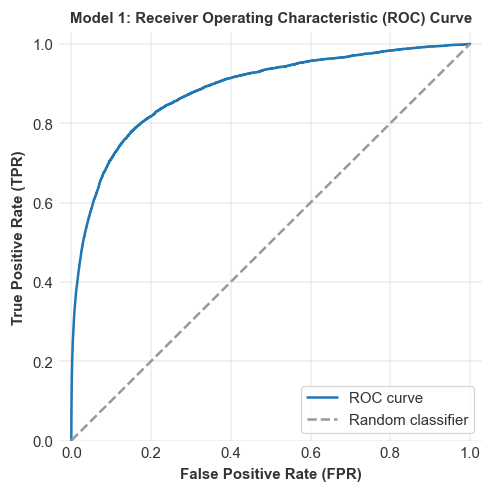

In [31]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

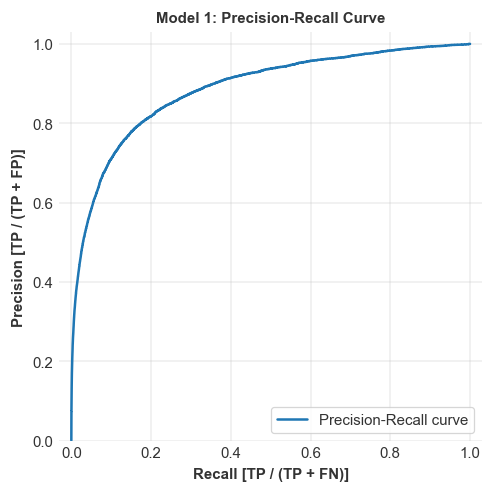

In [32]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [33]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
17,ab_nicu,138695.224852
38,mage_c,68208.093140
34,dbwt,28011.844788
27,ca_disor,24618.522131
22,ca_cchd,17503.220316
3,gestrec10,15390.074788
36,wtgain,13692.945706
37,bmi,11637.072047
35,pwgt_r,10018.954244
15,ab_aven1,6504.099929


In [34]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [35]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
22,ca_cchd,0.011487,0.000253
27,ca_disor,0.011150,0.000258
38,mage_c,0.009250,0.000455
17,ab_nicu,0.005170,0.000506
34,dbwt,0.003640,0.000316
3,gestrec10,0.002393,0.000382
13,dmeth_rec,0.001297,0.000214
36,wtgain,0.000803,0.000223
0,bfacil3,0.000648,0.000210
28,meduc,0.000579,0.000137


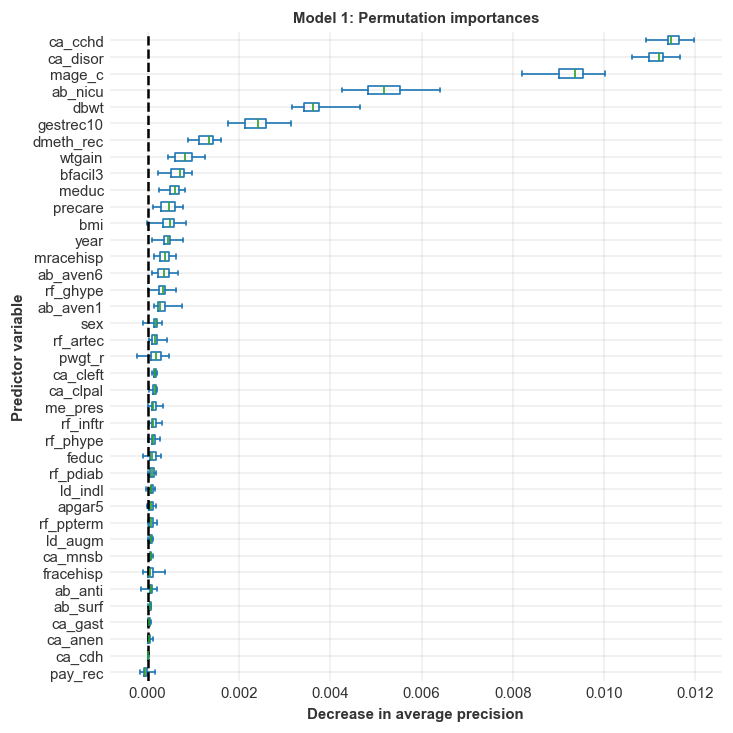

In [36]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

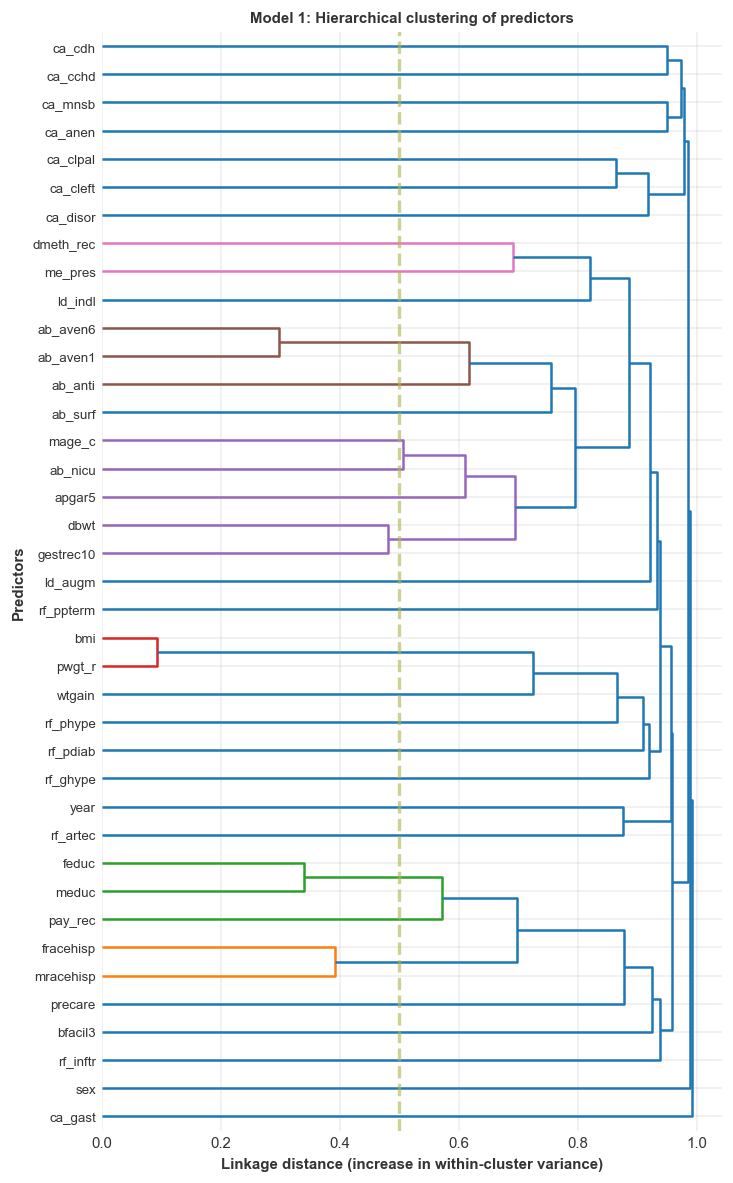

In [37]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

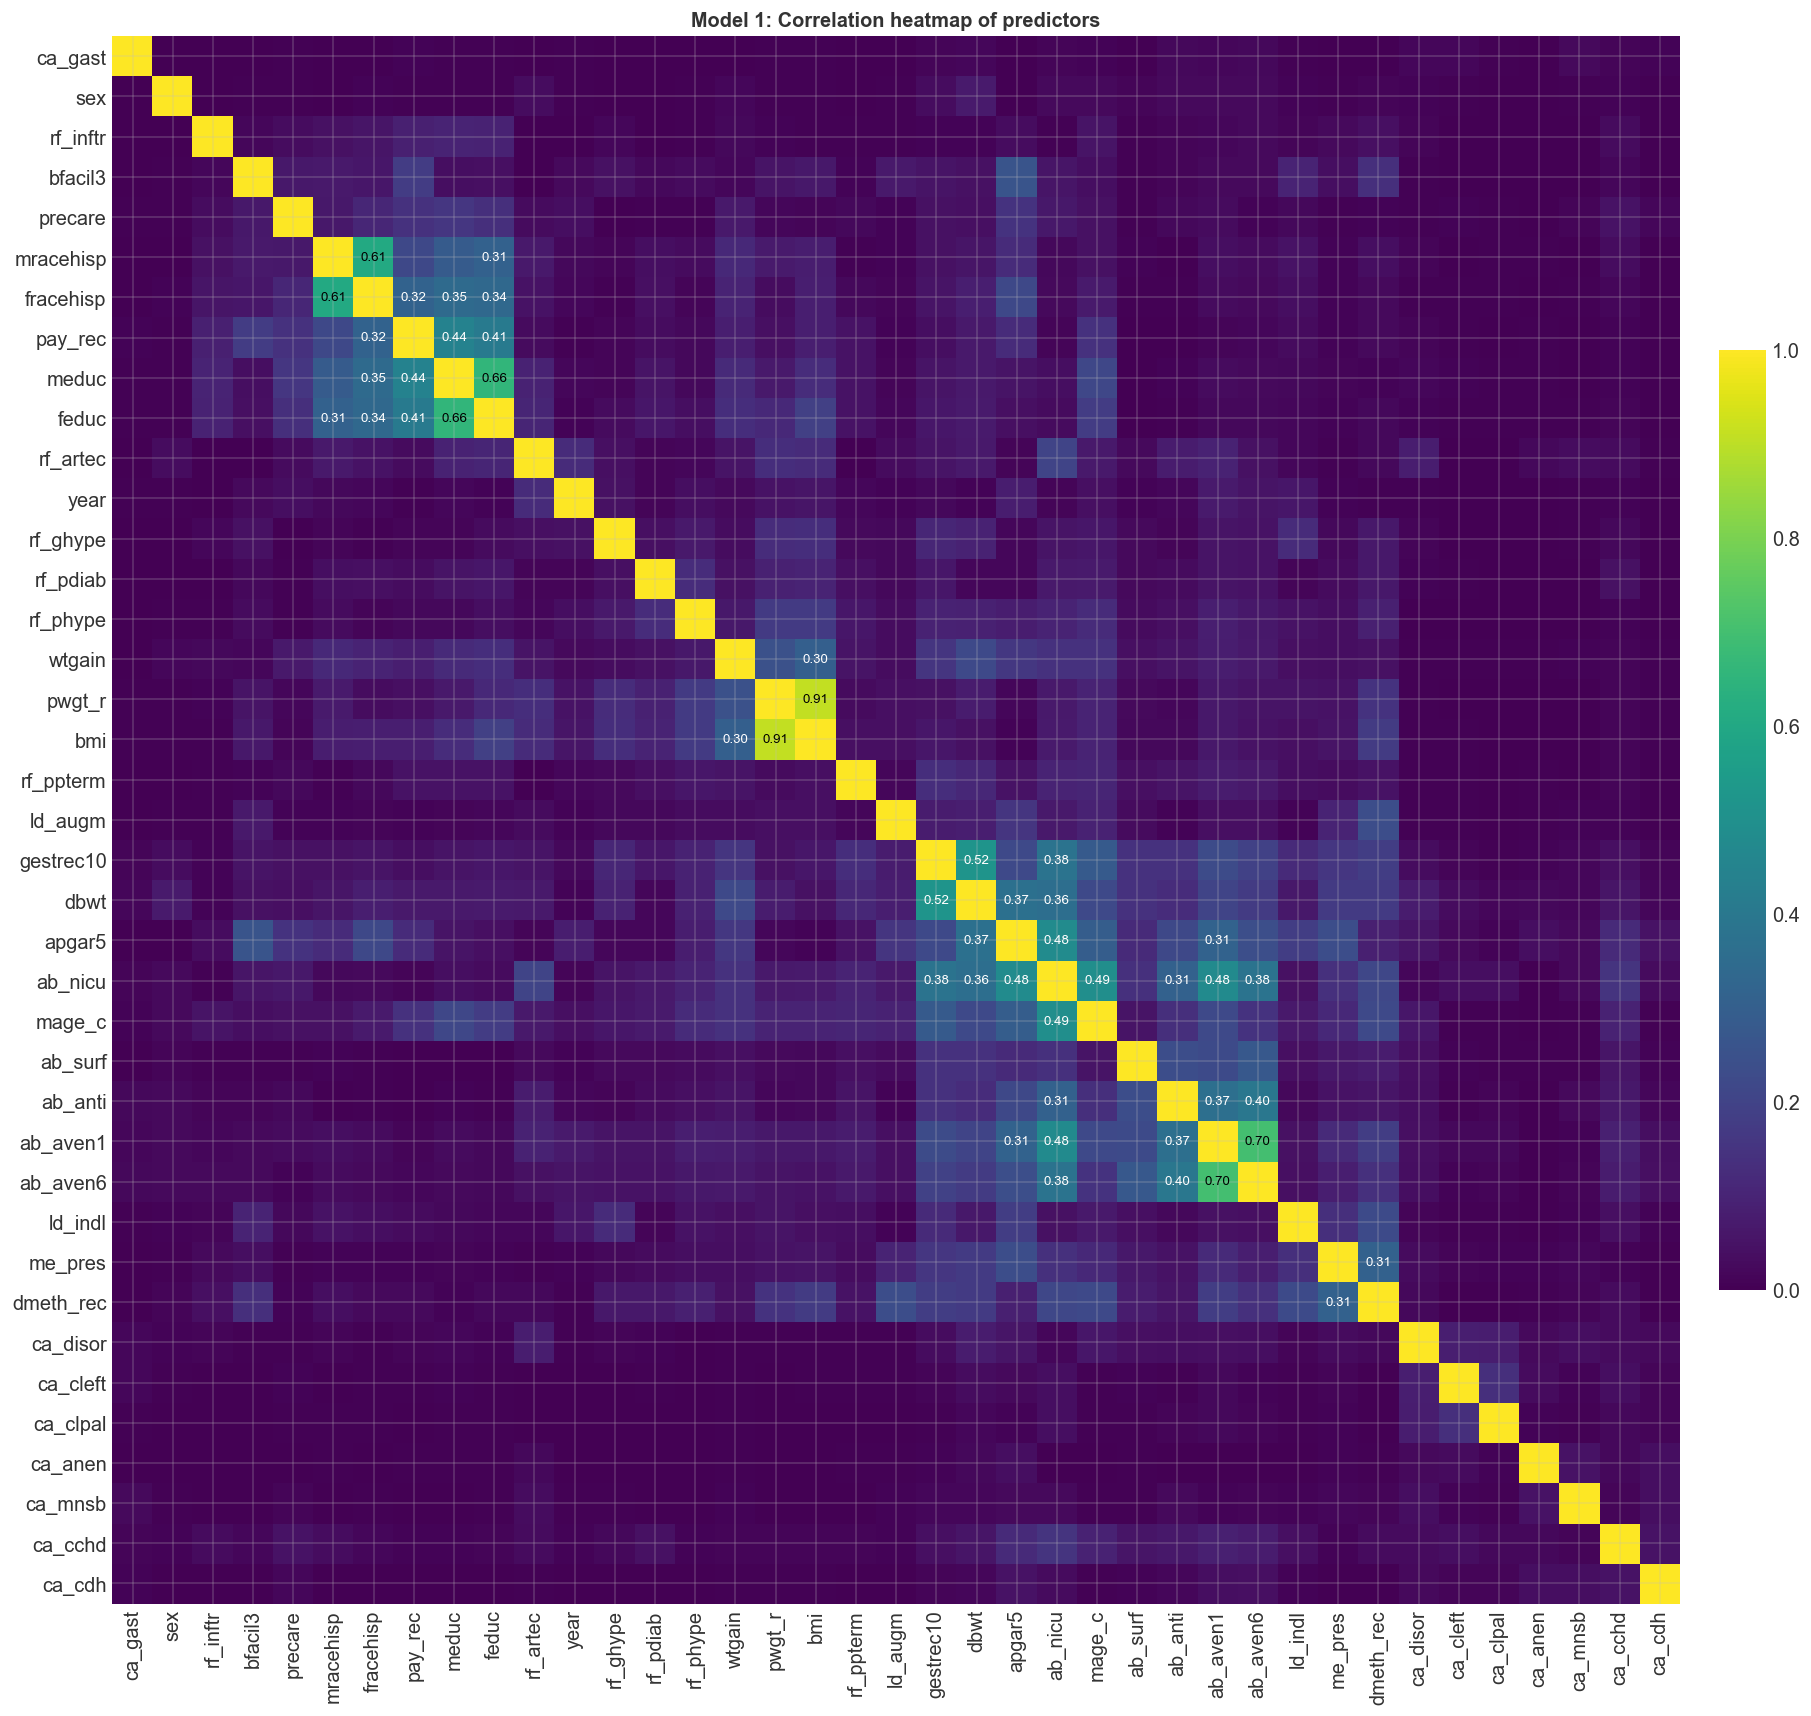

In [38]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [39]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clusterin

,feature,mean_abs_shap
17,ab_nicu,1.032189
38,mage_c,0.793333
3,gestrec10,0.322874
34,dbwt,0.321097
15,ab_aven1,0.185072
29,mracehisp,0.118143
22,ca_cchd,0.114990
27,ca_disor,0.097184
36,wtgain,0.085055
16,ab_aven6,0.069989


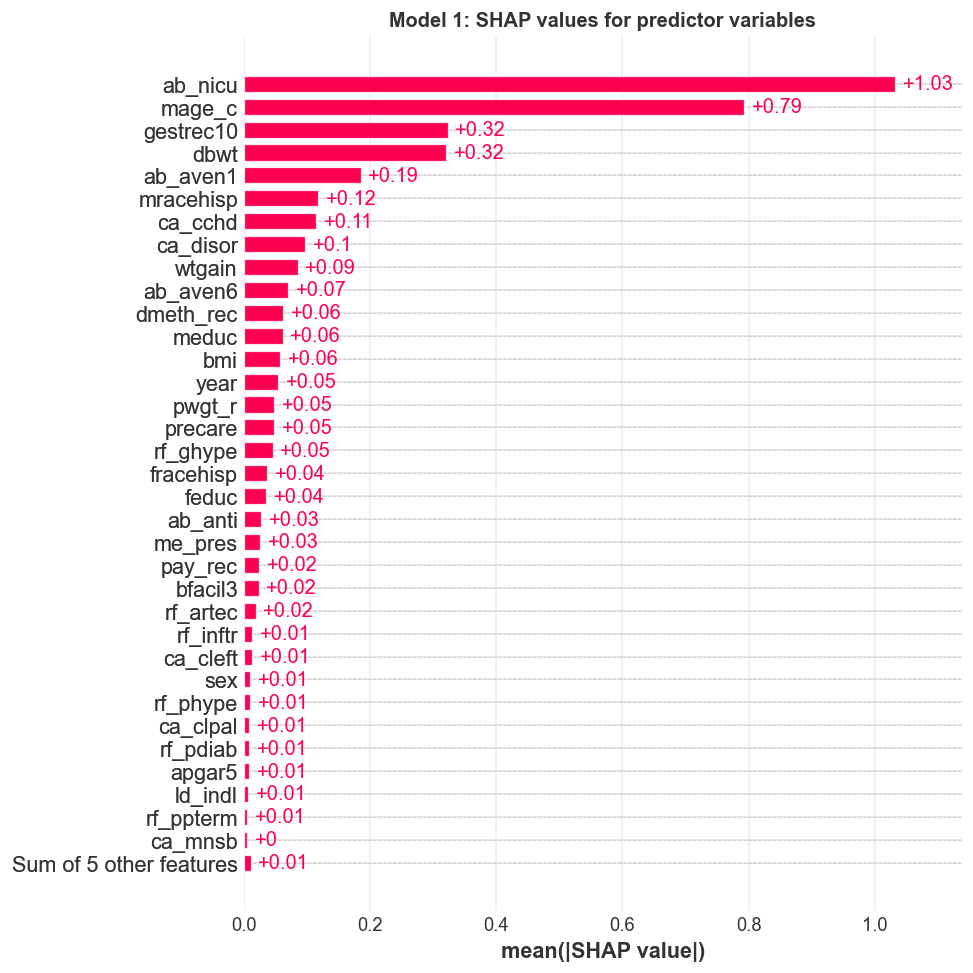

<Figure size 492x348 with 0 Axes>

In [40]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

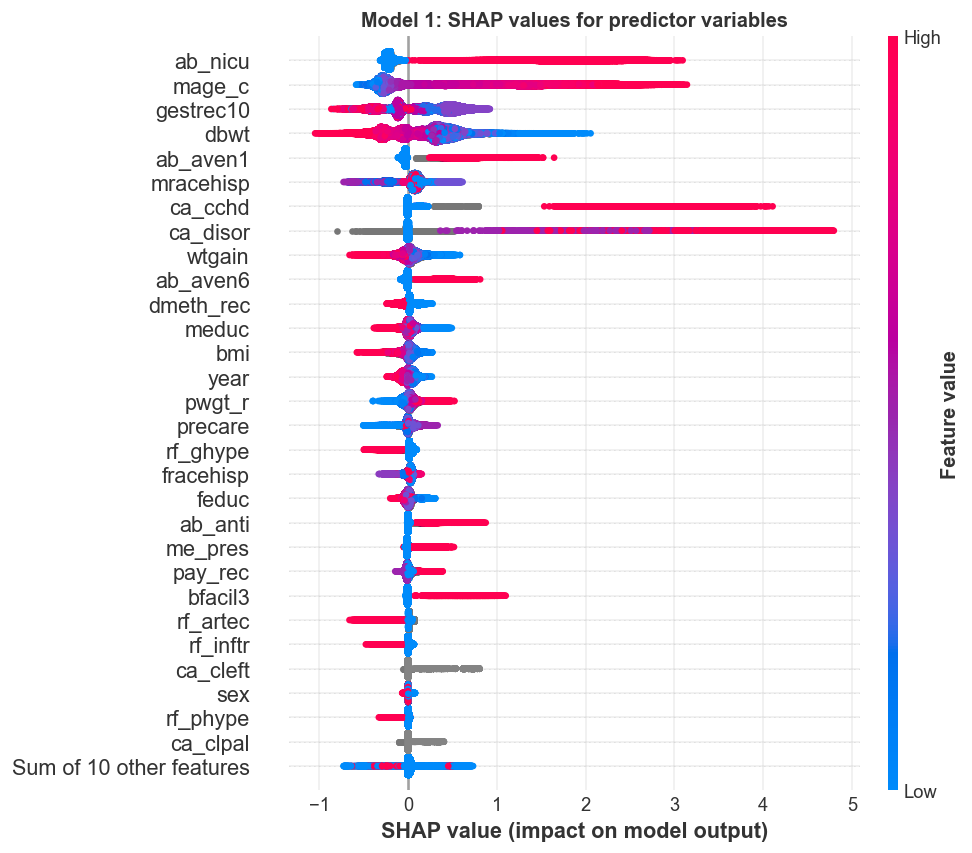

<Figure size 492x348 with 0 Axes>

In [41]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

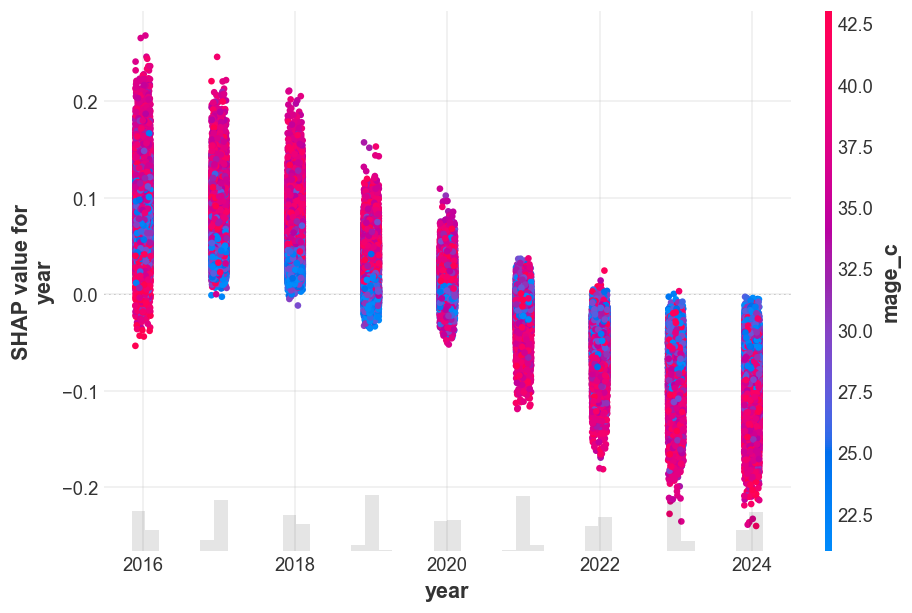

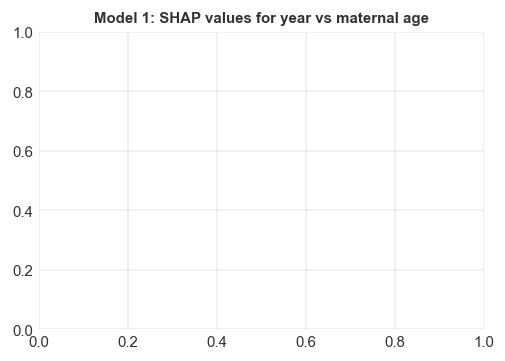

In [42]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 2


In [43]:
features_to_remove_1 = [
    "pwgt_r",
    "feduc",
    "fracehisp",

    "rf_pdiab",
    "apgar5",
    "ld_indl",
    "rf_ppterm",
    "ca_mnsb",
    "ca_gast",
    "ld_augm",
    "ca_anen",
    "ab_surf",
    "ca_cdh",
]

X_train = X_train.drop(columns=features_to_remove_1)
X_valid = X_valid.drop(columns=features_to_remove_1)
X_cal = X_cal.drop(columns=features_to_remove_1)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_1]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 2
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_1)} predictors)"
)

print(f"Features removed: {features_to_remove_1}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['pwgt_r', 'feduc', 'fracehisp', 'rf_pdiab', 'apgar5', 'ld_indl', 'rf_ppterm', 'ca_mnsb', 'ca_gast', 'ld_augm', 'ca_anen', 'ab_surf', 'ca_cdh']
Features remaining: ['bfacil3', 'sex', 'precare', 'gestrec10', 'rf_phype', 'rf_ghype', 'rf_inftr', 'rf_artec', 'me_pres', 'dmeth_rec', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_anti', 'ca_cchd', 'ca_cleft', 'ca_clpal', 'ca_disor', 'meduc', 'mracehisp', 'pay_rec', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c']
Number of features in Model 2 (after removing 13 predictors): 26


In [44]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 7124, number of negative: 13428567
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 13435691, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000530 -> initscore=-7.541670
[LightGBM] [Info] Start training from score -7.541670
Training until validation scores don't improve for 50 rounds
[10]	train's average_precision: 0.0261321	train's binary_logloss: 0.0039905	valid's average_precision: 0.0241288	valid's binary_logloss: 0.00401985
[20]	train's average_precision: 0.0305014	train's binary_logloss: 0.00380996	valid's average_precision: 0.0273336	valid's binary_logloss: 0.00385702
[30]	train's average_precision: 0.0330991	train's binary_logloss: 0.00370744	valid's average_precision: 0.0284964	valid's binary_logloss: 0.00376899
[40]	train's average_precision: 0.0357293	train's binary_logloss: 0.00364351	valid's average_precision: 0.0294041	valid's binary_logloss: 0.00371819
[50]	tra

In [45]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [46]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.885776
1,Validation AP,0.031613
2,Validation log loss,0.003616
3,Precision at 10000,0.082900
4,Recall at 10000,0.116384
5,Precision (threshold=0.01),0.026861
6,Recall (threshold=0.01),0.281202


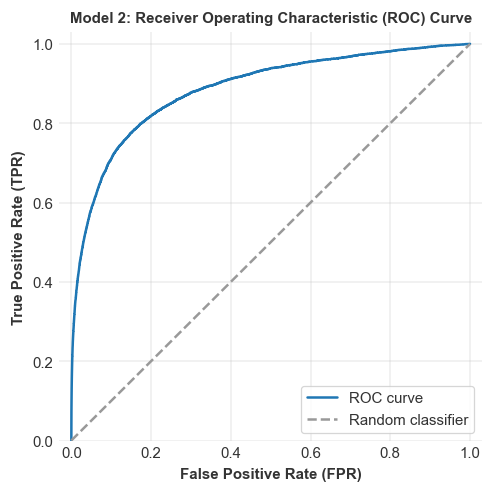

In [47]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

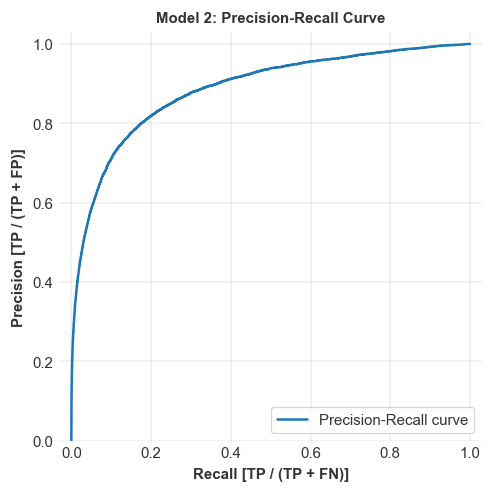

In [48]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [49]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
12,ab_nicu,136841.548753
25,mage_c,67772.996348
22,dbwt,28115.091349
17,ca_disor,25200.977683
14,ca_cchd,18897.476872
3,gestrec10,15414.469672
24,bmi,14205.380476
23,wtgain,13473.966503
10,ab_aven1,7671.645783
19,mracehisp,6317.016320


In [50]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [51]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
17,ca_disor,0.011391,0.000370
14,ca_cchd,0.011205,0.000227
25,mage_c,0.009057,0.000382
12,ab_nicu,0.004268,0.000496
22,dbwt,0.003654,0.000214
3,gestrec10,0.002105,0.000277
9,dmeth_rec,0.001323,0.000243
19,mracehisp,0.000773,0.000132
18,meduc,0.000719,0.000214
23,wtgain,0.000712,0.000235


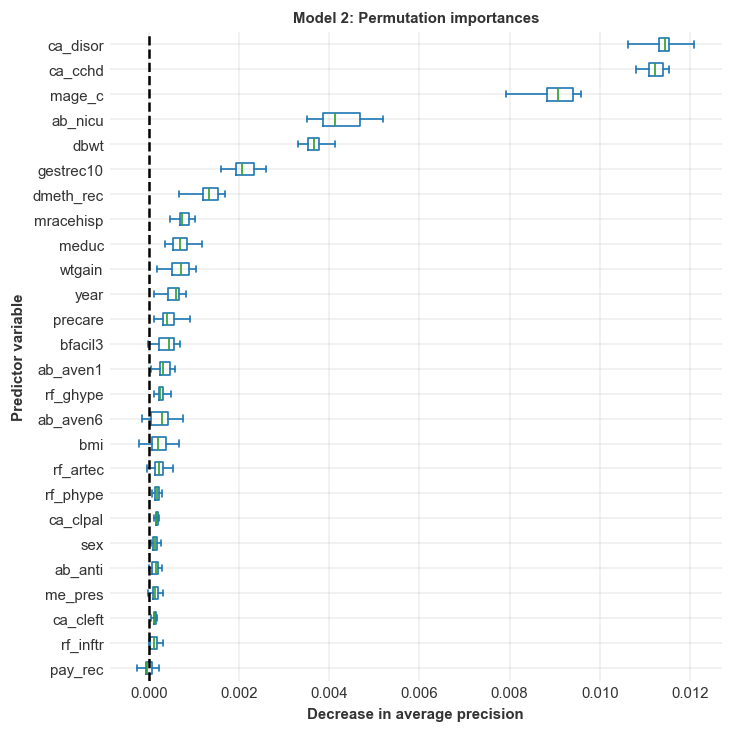

In [52]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

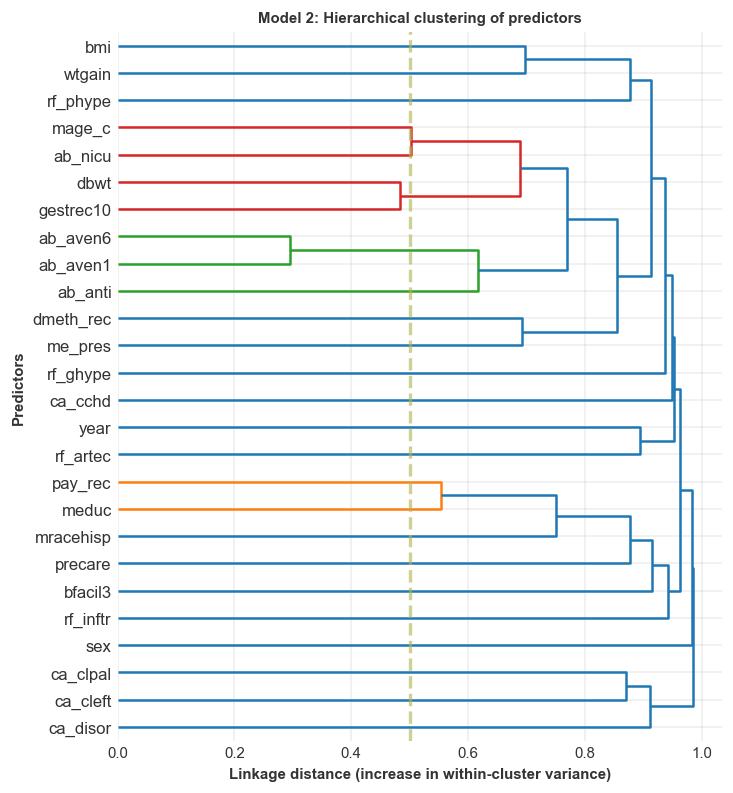

In [53]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

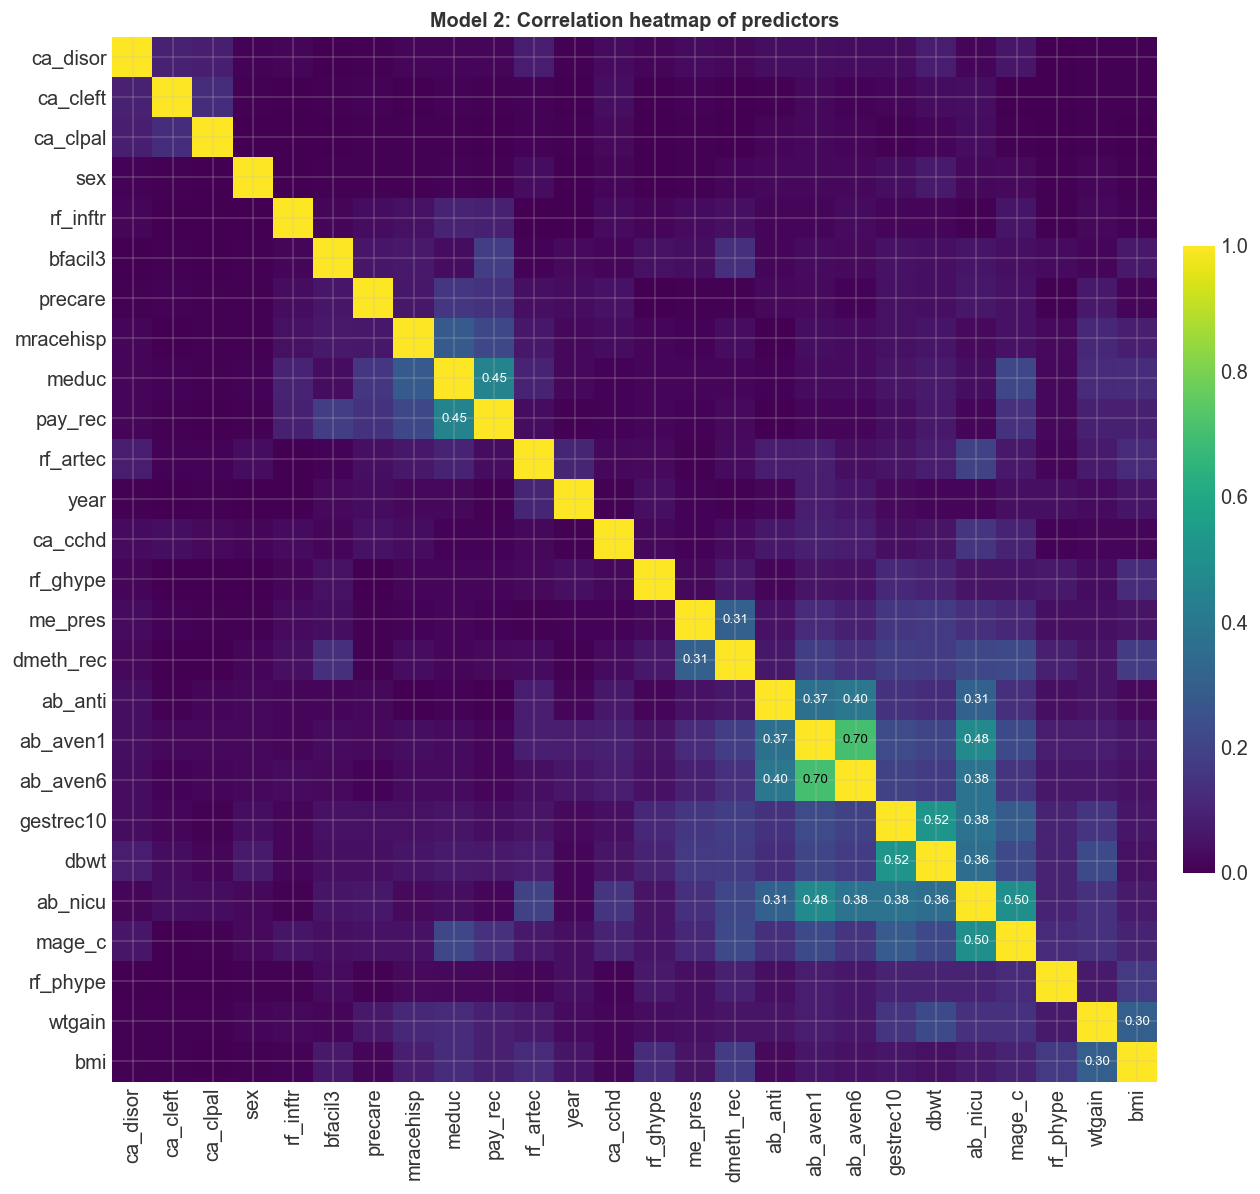

In [54]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [55]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clusterin

,feature,mean_abs_shap
12,ab_nicu,1.015769
25,mage_c,0.788514
22,dbwt,0.316222
3,gestrec10,0.314597
10,ab_aven1,0.187296
19,mracehisp,0.136573
14,ca_cchd,0.124565
17,ca_disor,0.101378
23,wtgain,0.085036
11,ab_aven6,0.070909


In [56]:
shap_importance["feature"].tolist()

['ab_nicu',
 'mage_c',
 'dbwt',
 'gestrec10',
 'ab_aven1',
 'mracehisp',
 'ca_cchd',
 'ca_disor',
 'wtgain',
 'ab_aven6',
 'dmeth_rec',
 'meduc',
 'year',
 'bmi',
 'precare',
 'rf_ghype',
 'ab_anti',
 'me_pres',
 'pay_rec',
 'bfacil3',
 'rf_artec',
 'ca_clpal',
 'rf_inftr',
 'sex',
 'rf_phype',
 'ca_cleft']

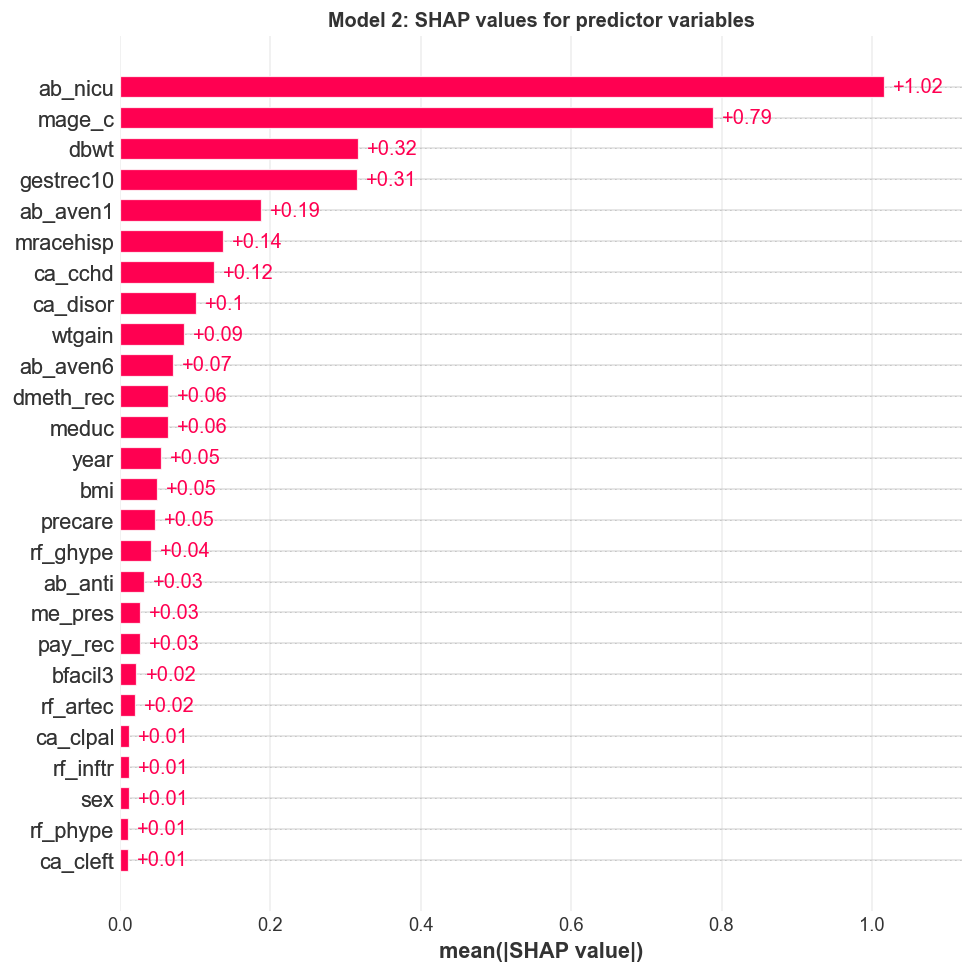

<Figure size 492x348 with 0 Axes>

In [57]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

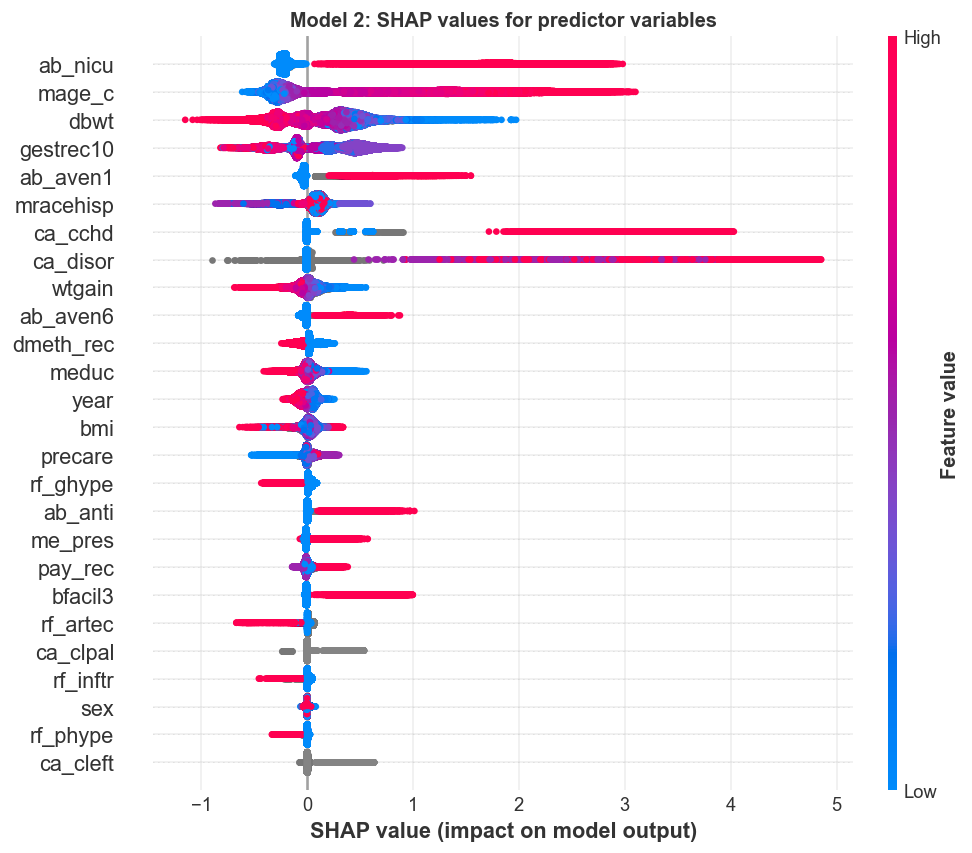

<Figure size 492x348 with 0 Axes>

In [58]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

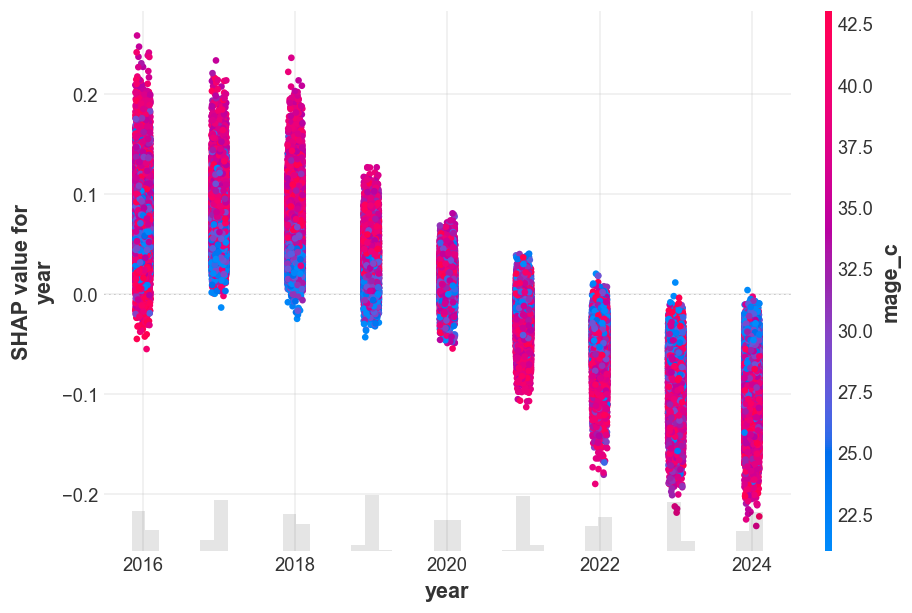

<Figure size 492x348 with 0 Axes>

In [78]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Calibration


In [ ]:
# LightGBM margins (log-odds)
s_cal = gbm.predict(X_cal, num_iteration=gbm.best_iteration, raw_score=True)

# Fit Platt calibrator on margins
calibrator = LogisticRegression(solver="lbfgs", max_iter=2000)
calibrator.fit(s_cal.reshape(-1, 1), y_cal)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [62]:
def predict_proba_calibrated(gbm, calibrator, X_new, num_iteration=None):
    p_raw = gbm.predict(X_new, num_iteration=num_iteration, raw_score=True)
    return calibrator.predict_proba(p_raw.reshape(-1, 1))[:, 1]

## Prediction


In [63]:
p_valid_cal = predict_proba_calibrated(
    gbm, calibrator, X_valid, num_iteration=gbm.best_iteration
)

p_valid_raw = gbm.predict(X_valid, num_iteration=gbm.best_iteration, raw_score=False)

print("best_iteration:", gbm.best_iteration)
print("mean raw prob:", float(p_valid_raw.mean()))
print("mean cal prob:", float(p_valid_cal.mean()))


print("Raw logloss:", log_loss(y_valid, p_valid_raw, labels=[0, 1]))
print("Cal logloss:", log_loss(y_valid, p_valid_cal, labels=[0, 1]))
print("Raw brier:  ", brier_score_loss(y_valid, p_valid_raw))
print("Cal brier:  ", brier_score_loss(y_valid, p_valid_cal))

best_iteration: 143
mean raw prob: 0.0005251857168452347
mean cal prob: 0.0005251493162735113
Raw logloss: 0.0036158942345478236
Cal logloss: 0.00361681448235844
Raw brier:   0.0005206138383873171
Cal brier:   0.0005206607681891005


In [64]:
def tail_calibration_table(y, p, fracs=(1e-2, 1e-3, 1e-4, 1e-5)):
    """
    Compare predicted vs observed event rates in the top fracs of scores.

    Parameters
    ----------
    y : array-like (0/1)
    p : array-like (probabilities)
    fracs : iterable of floats
        Fractions like 1e-3 for top 0.1%.

    Returns
    -------
    DataFrame with k, predicted mean, observed rate, and counts.
    """
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)

    order = np.argsort(-p)
    y_sorted = y[order]
    p_sorted = p[order]

    N = len(y)
    rows = []
    for f in fracs:
        k = max(1, int(round(N * f)))
        y_top = y_sorted[:k]
        p_top = p_sorted[:k]

        obs_rate = y_top.mean()
        pred_rate = p_top.mean()

        tp = int(y_top.sum())
        fp = int(k - tp)

        rows.append(
            {
                "top_frac": f,
                "k": k,
                "pred_rate_mean": pred_rate,
                "obs_rate": obs_rate,
                "tp": tp,
                "fp": fp,
                "pred_minus_obs": pred_rate - obs_rate,
                "ratio_pred_to_obs": (pred_rate / obs_rate) if obs_rate > 0 else np.nan,
            }
        )

    return pd.DataFrame(rows)

In [65]:
fracs = (1e-2, 1e-3, 1e-4, 1e-5)  # 1%, 0.1%, 0.01%, 0.001%

calibration_table_raw = tail_calibration_table(y_valid, p_valid_raw, fracs=fracs)
calibration_table_cal = tail_calibration_table(y_valid, p_valid_cal, fracs=fracs)

calibration_table_raw["model"] = "raw"
calibration_table_cal["model"] = "calibrated"
calibration_table_combined = pd.concat(
    [calibration_table_raw, calibration_table_cal], ignore_index=True
)

calibration_table_combined.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_tail_calibration_table.csv",
    index=False,
)

calibration_table_combined

,top_frac,k,pred_rate_mean,obs_rate,tp,fp,pred_minus_obs,ratio_pred_to_obs,model
0,0.01000,134357,0.018228,0.018436,2477,131880,-0.000208,0.988701,raw
1,0.00100,13436,0.069587,0.073236,984,12452,-0.003649,0.950178,raw
2,0.00010,1344,0.178634,0.184524,248,1096,-0.005890,0.968081,raw
3,0.00001,134,0.312105,0.223881,30,104,0.088224,1.394067,raw
4,0.01000,134357,0.017471,0.018436,2477,131880,-0.000965,0.947653,calibrated
5,0.00100,13436,0.065546,0.073236,984,12452,-0.007690,0.894992,calibrated
6,0.00010,1344,0.166844,0.184524,248,1096,-0.017680,0.904186,calibrated
7,0.00001,134,0.291727,0.223881,30,104,0.067846,1.303046,calibrated


In [66]:
gbm.save_model(
    f"{OUTPUT_DIR}/final_model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [67]:
joblib.dump(calibrator, f"{OUTPUT_DIR}/final_calibrator.joblib")

meta = {
    "features": list(X_train.columns),
    "best_iteration": int(getattr(gbm, "best_iteration", 0) or 0),
    "calibration_input": "raw_score",  # or "prob"
}

joblib.dump(meta, f"{OUTPUT_DIR}/final_model_meta.joblib")

['output/0008-predictors-6/20251226-203008/final_model_meta.joblib']

In [ ]:
X_full = df[features]

categorical = [col for col in categorical if col in X_full.columns]

X_full[categorical] = X_full[categorical].astype("category")

p_full_cal = predict_proba_calibrated(
    gbm, calibrator, X_full, num_iteration=gbm.best_iteration
)




In [79]:
p_full = gbm.predict(X_full, num_iteration=gbm.best_iteration)  # P(S=1|X)

In [71]:
df["p_ds_lb_pred_01"] = p_full_cal

In [80]:
df["p_ds_lb_pred_01b"] = p_full

In [81]:
df[["year", "p_ds_lb_pred_01", "p_ds_lb_pred_01b", "ca_down_c_p_n"]].groupby("year").sum().reset_index()

,year,p_ds_lb_pred_01,p_ds_lb_pred_01b,ca_down_c_p_n
0,2016,1981.586001,1978.753016,2168
1,2017,1996.471238,1995.255307,2044
2,2018,2037.892186,2039.762838,2108
3,2019,2015.282053,2017.534667,2030
4,2020,1956.504382,1959.420429,1954
5,2021,1955.848513,1956.652862,1903
6,2022,1890.421268,1888.323455,1861
7,2023,1871.665307,1870.497759,1855
8,2024,1910.571563,1909.460652,1886


In [ ]:
import duckdb

con = duckdb.connect("./data/us_births.db")

In [ ]:
con.execute(
    """
    ALTER TABLE us_births ADD COLUMN IF NOT EXISTS p_ds_lb_pred_01 DOUBLE;
    """
)
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")
con.execute(f"CREATE TABLE ds_lb_pred_01 (id BIGINT, p_ds_lb_pred DOUBLE)")

In [ ]:
con.execute(
    """
    INSERT INTO ds_lb_pred_01 (id, p_ds_lb_pred)
    SELECT id, p_ds_lb_pred_01
    FROM df
    """
)

In [ ]:
con.execute(
    """
    UPDATE us_births b
    SET p_ds_lb_pred_01 = p.p_ds_lb_pred
    FROM ds_lb_pred_01 p
    WHERE b.id = p.id;
    """
)

In [ ]:
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")

In [ ]:
con.close()